# 🎬 UCF-Crime Anomaly Detection - Complete Pipeline
## STGNN + Transformer untuk Deteksi Anomali Video Pengawasan

**Pipeline Lengkap:**
1. ⚙️ **Setup & Konfigurasi**
2. 📊 **Dataset Overview** - Statistik dan visualisasi
3. 🔍 **Object Detection** - YOLOv9 + Fire model
4. 🕸️ **Graph Building** - Konstruksi graf spatio-temporal
5. 📂 **Dataset Split** - Stratified train/val
6. 🧠 **Model Definition** - STGNN + Transformer
7. 🏋️ **Training** - Focal Loss, AMP, Early Stopping
8. 📈 **Evaluation** - Metrics, ROC, Confusion Matrix
9. 🎯 **Inference** - Single video prediction
10. 🔬 **Explainability** - Node importance

---
## 1️⃣ Setup & Konfigurasi

In [2]:
# =============================================================================
# CELL 1: Import & Configuration
# =============================================================================
import os, sys, json, math, time, random, gc, warnings
from pathlib import Path
from typing import List, Tuple, Optional, Dict
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_style('whitegrid')
except: sns = None

from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

try:
    from ultralytics import YOLO
    YOLO_AVAILABLE = True
except: YOLO_AVAILABLE = False

warnings.filterwarnings('ignore')

# =============================================================================
# REPRODUCIBILITY
# =============================================================================
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

# =============================================================================
# PATHS
# =============================================================================
NB_ROOT = Path(os.getcwd())
ROOT = NB_ROOT / 'DatasetTA'

RAW_DIR = ROOT / 'project_data' / 'raw'
DETECTIONS_DIR = ROOT / 'project_data' / 'detections'
FEATURES_DIR = ROOT / 'project_data' / 'features'
GRAPHS_DIR = ROOT / 'project_data' / 'graphs'
MODELS_DIR = ROOT / 'project_data' / 'models'
ANALYSIS_DIR = ROOT / 'project_data' / 'analysis'

for p in [RAW_DIR, DETECTIONS_DIR, FEATURES_DIR, GRAPHS_DIR, MODELS_DIR, ANALYSIS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

YOLO_WEIGHTS = NB_ROOT / 'yolov9s.pt'
FIRE_MODEL_PATH = NB_ROOT / 'fire_model.pt'

# =============================================================================
# DEVICE
# =============================================================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
USE_AMP = torch.cuda.is_available()

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    gc.collect()

# =============================================================================
# PIPELINE FLAGS
# =============================================================================
RUN_DETECTION = False       # Set True untuk jalankan deteksi
FORCE_GRAPH_REBUILD = False # Set True untuk rebuild semua graph
RUN_TRAINING = True         # Set True untuk training

# =============================================================================
# HYPERPARAMETERS
# =============================================================================
# Detection
DET_CONF_THRESH = 0.4
DET_FRAME_SKIP = 2
YOLO_CLASSES = {'person', 'car', 'truck', 'motorcycle', 'bicycle', 'knife', 'dog'}

# Graph Building
GRAPH_FRAME_STRIDE = 2
GRAPH_DISTANCE_THRESH = 100.0
GRAPH_TOPK_SPATIAL = 5
GRAPH_TOPK_TEMPORAL = 3

# Model
HIDDEN_DIM = 128
OUTPUT_DIM = 128
NUM_GCN_LAYERS = 3
DROPOUT = 0.3

# Training
EPOCHS = 40
LR = 5e-4
LR_MIN = 1e-5
BATCH_ACCUM = 4
MAX_SEGMENTS = 8
MAX_NODES = 300
PATIENCE = 8
LABEL_SMOOTHING = 0.1

# Labels
ANOM_CLASSES = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion',
                'Fighting','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

print('='*60)
print('⚙️ CONFIGURATION')
print('='*60)
print(f'Device: {DEVICE}')
print(f'Paths: ROOT={ROOT}')
print(f'Model: HIDDEN={HIDDEN_DIM}, GCN_LAYERS={NUM_GCN_LAYERS}')
print(f'Training: EPOCHS={EPOCHS}, LR={LR}')
print(f'Flags: RUN_DETECTION={RUN_DETECTION}, RUN_TRAINING={RUN_TRAINING}')

%matplotlib inline

c:\Users\MAHARDIKA\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


⚙️ CONFIGURATION
Device: cuda
Paths: ROOT=c:\Kuliah\TA\TA BARU\DatasetTA
Model: HIDDEN=128, GCN_LAYERS=3
Training: EPOCHS=40, LR=0.0005
Flags: RUN_DETECTION=False, RUN_TRAINING=True


---
## 2️⃣ Dataset Overview

📹 Found 1950 videos in c:\Kuliah\TA\TA BARU\DatasetTA\project_data\raw

📊 Class Distribution:
class
Normal         1150
Robbery         150
Stealing        100
Burglary        100
Abuse            50
Assault          50
Arson            50
Arrest           50
Fighting         50
Explosion        50
Shooting         50
Shoplifting      50
Vandalism        50

📈 Label: Normal=1150, Anomaly=800


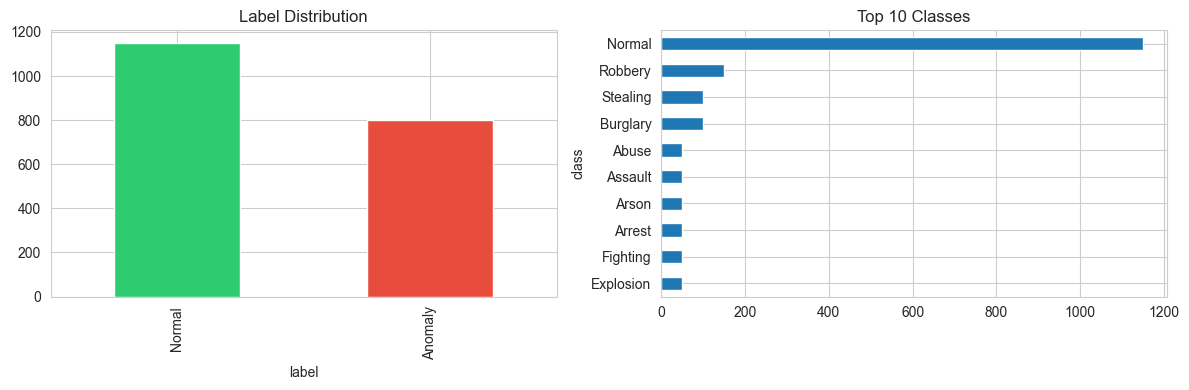

In [3]:
# =============================================================================
# CELL 2: Dataset Overview
# =============================================================================
VIDEO_EXTS = ('.mp4', '.avi', '.mkv', '.mov')
video_files = sorted([Path(root)/f for root,_,files in os.walk(RAW_DIR) 
                      for f in files if f.lower().endswith(VIDEO_EXTS)])

print(f'📹 Found {len(video_files)} videos in {RAW_DIR}')

def get_class(p): 
    for c in ANOM_CLASSES:
        if c in '/'.join(p.parts): return c
    return 'Normal'

def get_label(p): return 0 if get_class(p)=='Normal' else 1

if len(video_files):
    df = pd.DataFrame({
        'filename': [p.name for p in video_files],
        'class': [get_class(p) for p in video_files],
        'label': [get_label(p) for p in video_files]
    })
    print('\n📊 Class Distribution:')
    print(df['class'].value_counts().to_string())
    print(f'\n📈 Label: Normal={sum(df.label==0)}, Anomaly={sum(df.label==1)}')
    
    if sns:
        fig, ax = plt.subplots(1,2,figsize=(12,4))
        df['label'].value_counts().plot(kind='bar', ax=ax[0], color=['#2ecc71','#e74c3c'])
        ax[0].set_xticklabels(['Normal','Anomaly']); ax[0].set_title('Label Distribution')
        df['class'].value_counts().head(10).plot(kind='barh', ax=ax[1])
        ax[1].set_title('Top 10 Classes'); ax[1].invert_yaxis()
        plt.tight_layout(); plt.show()

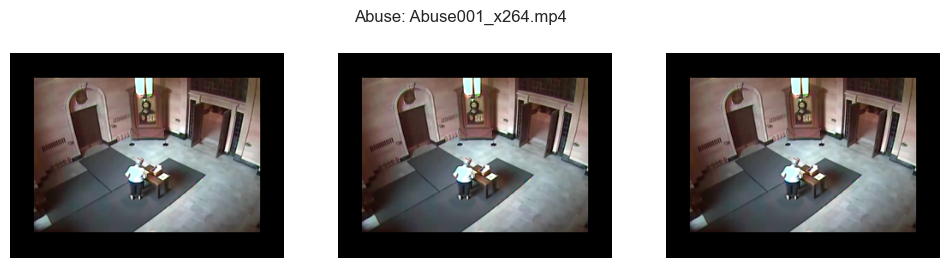

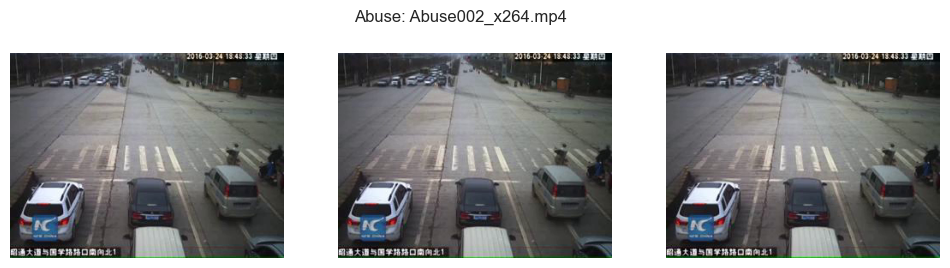

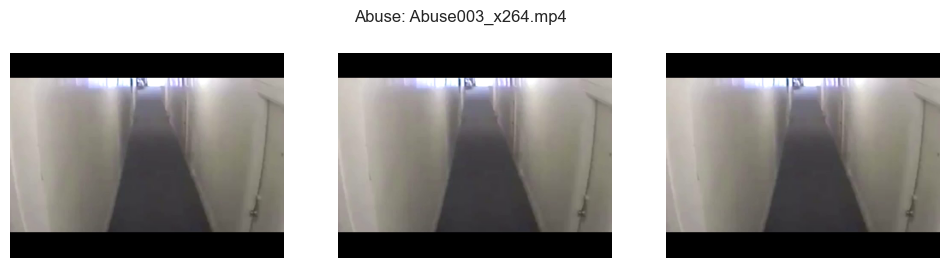

In [4]:
# =============================================================================
# CELL 2b: Sample Frames Visualization
# =============================================================================
N_SHOW = 3
for i, vp in enumerate(video_files[:N_SHOW], 1):
    cap = cv2.VideoCapture(str(vp))
    frames = []
    for _ in range(3):
        ret, fr = cap.read()
        if not ret: break
        frames.append(cv2.cvtColor(fr, cv2.COLOR_BGR2RGB))
    cap.release()
    
    if frames:
        fig, axs = plt.subplots(1, len(frames), figsize=(12,3))
        if len(frames)==1: axs=[axs]
        for j, im in enumerate(frames):
            axs[j].imshow(im); axs[j].axis('off')
        plt.suptitle(f'{get_class(vp)}: {vp.name}')
        plt.show()

---
## 3️⃣ Object Detection (YOLOv9)

In [5]:
# =============================================================================
# CELL 3: Object Detection
# =============================================================================
print(f'YOLO available: {YOLO_AVAILABLE}, weights: {YOLO_WEIGHTS.exists()}')
print(f'Fire model: {FIRE_MODEL_PATH.exists()}')

def process_video_detection(video_path, yolo_model, fire_model=None, 
                           conf_thresh=DET_CONF_THRESH, frame_skip=DET_FRAME_SKIP):
    """Run detection on video and save results."""
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened(): return None
    
    is_fire = any(c in str(video_path) for c in ['Arson','Explosion'])
    use_fire = fire_model is not None and is_fire
    
    video_data = {
        'video': video_path.stem,
        'category': video_path.parent.name,
        'frames': []
    }
    
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame_idx += 1
        if frame_idx % frame_skip != 0: continue
        
        frame_objects = []
        
        # YOLO detection
        res = yolo_model.predict(frame, conf=conf_thresh, verbose=False)
        if res[0].boxes is not None:
            for box in res[0].boxes:
                lbl = yolo_model.names[int(box.cls)]
                if lbl in YOLO_CLASSES:
                    frame_objects.append({
                        'label': lbl, 'conf': float(box.conf),
                        'bbox': box.xyxy[0].cpu().numpy().tolist()
                    })
        
        # Fire detection (optional)
        if use_fire:
            try:
                res2 = fire_model.predict(frame, conf=0.3, verbose=False)
                if res2[0].boxes is not None:
                    for box in res2[0].boxes:
                        frame_objects.append({
                            'label': 'fire', 'conf': float(box.conf),
                            'bbox': box.xyxy[0].cpu().numpy().tolist()
                        })
            except: pass
        
        video_data['frames'].append({'frame_index': frame_idx, 'objects': frame_objects})
    
    cap.release()
    return video_data

# Run detection
if RUN_DETECTION and YOLO_AVAILABLE and YOLO_WEIGHTS.exists():
    print('🔍 Running detection...')
    yolo_model = YOLO(str(YOLO_WEIGHTS)).to(DEVICE)
    fire_model = YOLO(str(FIRE_MODEL_PATH)).to(DEVICE) if FIRE_MODEL_PATH.exists() else None
    
    for vp in tqdm(video_files, desc='Detection'):
        out_json = DETECTIONS_DIR / vp.relative_to(RAW_DIR).parent / f'{vp.stem}.json'
        if out_json.exists(): continue
        out_json.parent.mkdir(parents=True, exist_ok=True)
        
        det = process_video_detection(vp, yolo_model, fire_model)
        if det:
            with open(out_json, 'w') as f: json.dump(det, f)
    
    del yolo_model, fire_model
    torch.cuda.empty_cache()
    print('✅ Detection complete')
else:
    print(f'⏭️ Detection skipped. Found {len(list(DETECTIONS_DIR.rglob("*.json")))} existing files.')

YOLO available: True, weights: True
Fire model: True
⏭️ Detection skipped. Found 1950 existing files.


---
## 4️⃣ Graph Building

In [6]:
# =============================================================================
# CELL 4: Graph Building Functions
# =============================================================================
def bbox_center(bbox):
    x1,y1,x2,y2 = bbox
    return (0.5*(x1+x2), 0.5*(y1+y2))

def build_graph(json_path):
    """Build spatio-temporal graph from detection JSON."""
    with open(json_path) as f: det = json.load(f)
    
    node_features, node_frames = [], []
    frame_to_nodes = defaultdict(list)
    
    for fi, fr in enumerate(det.get('frames', [])):
        if GRAPH_FRAME_STRIDE > 1 and fi % GRAPH_FRAME_STRIDE != 0: continue
        frame_idx = fr.get('frame_index', fi)
        
        for obj in fr.get('objects', []):
            bbox = obj.get('bbox')
            if not bbox: continue
            feat = np.array(bbox + [obj.get('conf', 0.5)], dtype=np.float32)
            idx = len(node_features)
            node_features.append(feat)
            node_frames.append(frame_idx)
            frame_to_nodes[frame_idx].append(idx)
    
    if not node_features: return None
    
    x = torch.tensor(np.stack(node_features), dtype=torch.float32)
    edges = set()
    
    # Spatial edges
    for fi, nodes in frame_to_nodes.items():
        if len(nodes) <= 1: continue
        centers = np.array([bbox_center(x[i,:4].tolist()) for i in nodes])
        for ui, u in enumerate(nodes):
            dists = np.sqrt(((centers - centers[ui])**2).sum(1))
            for vj in np.argsort(dists)[1:GRAPH_TOPK_SPATIAL+1]:
                if dists[vj] > GRAPH_DISTANCE_THRESH: break
                edges.add((u, nodes[vj])); edges.add((nodes[vj], u))
    
    # Temporal edges
    sorted_frames = sorted(frame_to_nodes.keys())
    for i in range(len(sorted_frames)-1):
        f0, f1 = sorted_frames[i], sorted_frames[i+1]
        n0, n1 = frame_to_nodes[f0], frame_to_nodes[f1]
        if not n0 or not n1: continue
        c0 = np.array([bbox_center(x[u,:4].tolist()) for u in n0])
        c1 = np.array([bbox_center(x[v,:4].tolist()) for v in n1])
        for ui, u in enumerate(n0):
            dists = np.sqrt(((c1 - c0[ui])**2).sum(1))
            for vj in np.argsort(dists)[:GRAPH_TOPK_TEMPORAL]:
                if dists[vj] > GRAPH_DISTANCE_THRESH*1.5: break
                edges.add((u, n1[vj])); edges.add((n1[vj], u))
    
    ei = torch.tensor(list(edges), dtype=torch.long).T if edges else torch.empty((2,0), dtype=torch.long)
    g = Data(x=x, edge_index=ei)
    g.video_name = det.get('video', json_path.stem)
    g.node_frames = torch.tensor(node_frames, dtype=torch.long)
    return g

# Build all graphs
det_jsons = list(DETECTIONS_DIR.rglob('*.json'))
built, skipped = 0, 0

for jp in tqdm(det_jsons, desc='Building graphs'):
    out = GRAPHS_DIR / jp.relative_to(DETECTIONS_DIR).parent / f'{jp.stem}_graph.pt'
    out.parent.mkdir(parents=True, exist_ok=True)
    if out.exists() and not FORCE_GRAPH_REBUILD:
        skipped += 1; continue
    try:
        g = build_graph(jp)
        if g: torch.save(g, out); built += 1
    except Exception as e:
        print(f'Failed: {jp.name} - {e}')

print(f'\n📊 Graphs: built={built}, skipped={skipped}, total={len(list(GRAPHS_DIR.rglob("*_graph.pt")))}')

Building graphs: 100%|██████████| 1950/1950 [00:00<00:00, 4151.72it/s]


📊 Graphs: built=0, skipped=1942, total=1942


🕸️ VISUALISASI GRAF SPATIO-TEMPORAL

📊 Processing: Abuse001_x264
✅ Saved: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\analysis\graph_viz_Abuse001_x264.png


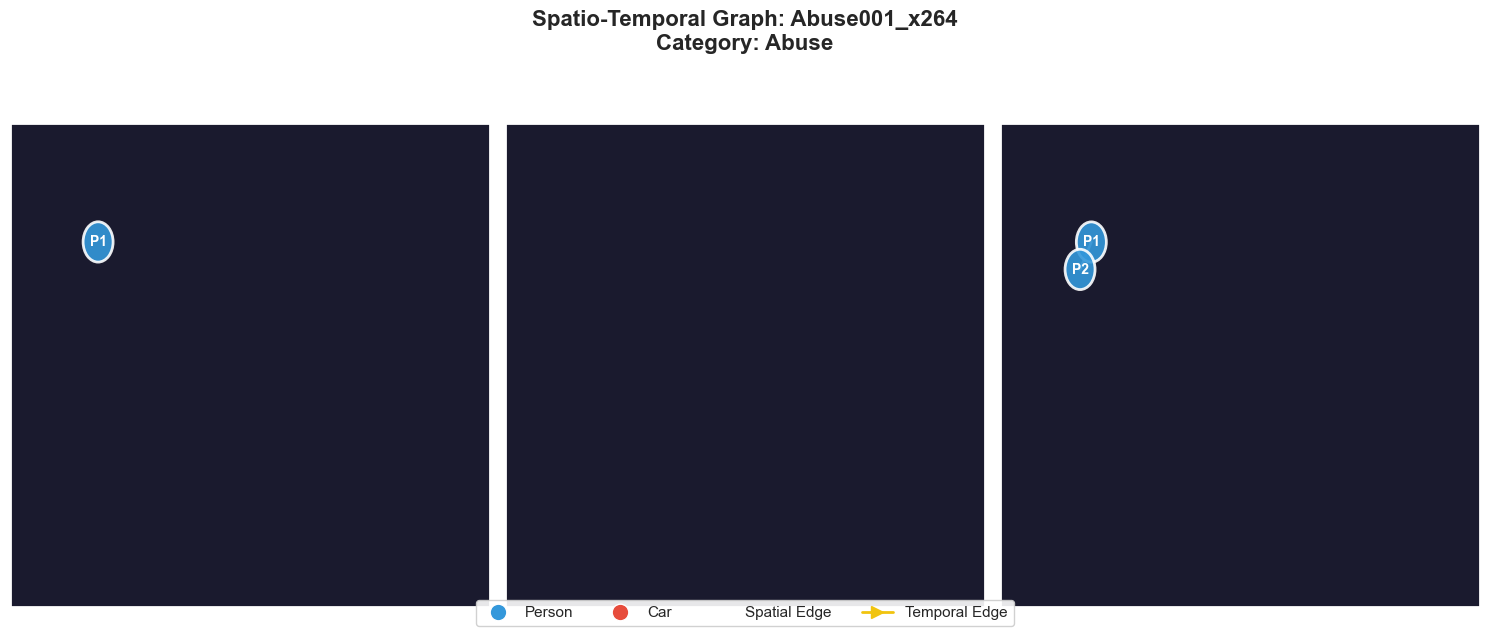


📊 Processing: Normal_Videos_015_x264
✅ Saved: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\analysis\graph_viz_Normal_Videos_015_x264.png


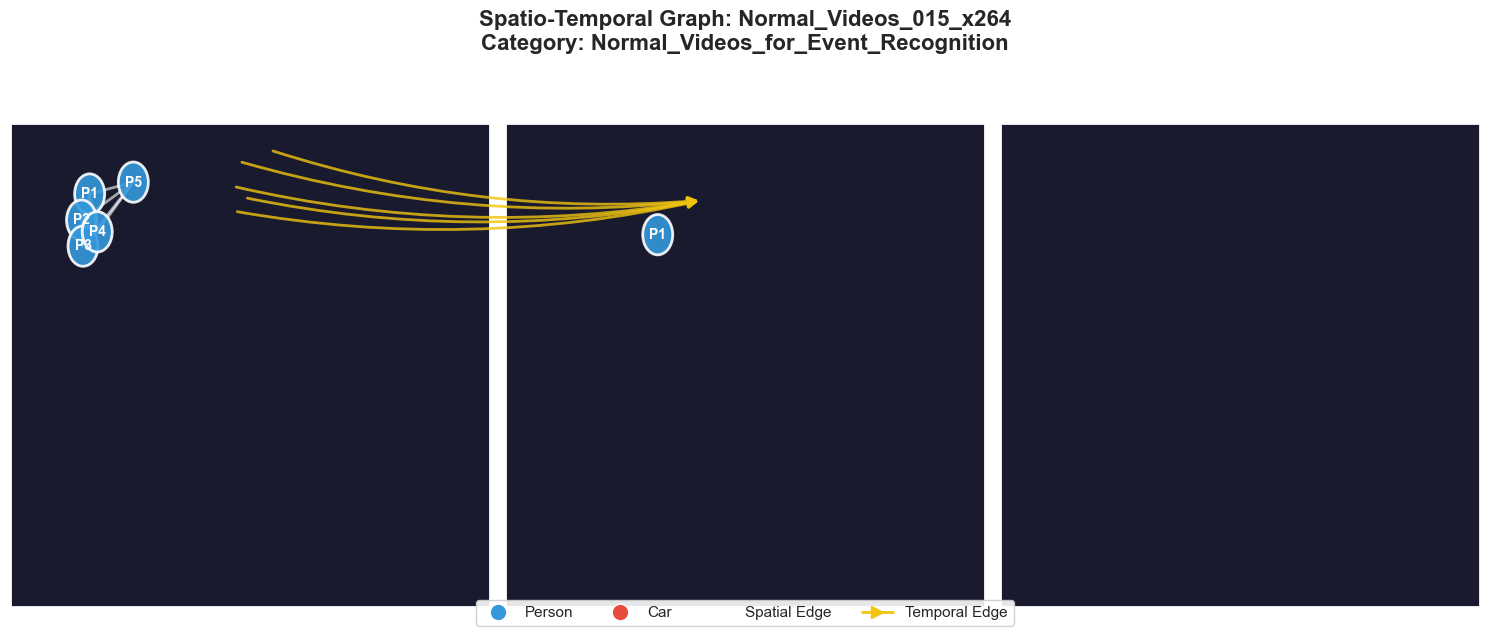

In [14]:
# =============================================================================
# CELL 4b: Visualisasi Graf Spatio-Temporal (untuk Paper/Tulisan)
# =============================================================================
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

def visualize_spatiotemporal_graph(json_path, num_frames=3, save_path=None):
    """
    Visualisasi graf spatio-temporal dari data deteksi.
    Menampilkan nodes (objek) dan edges (spatial + temporal).
    """
    # Load detection data
    with open(json_path) as f:
        det = json.load(f)
    
    frames_data = det.get('frames', [])
    if len(frames_data) < num_frames:
        print(f"Warning: Only {len(frames_data)} frames available")
        num_frames = len(frames_data)
    
    # Select evenly spaced frames
    indices = np.linspace(0, len(frames_data)-1, num_frames, dtype=int)
    selected_frames = [frames_data[i] for i in indices]
    
    # Create figure
    fig, axes = plt.subplots(1, num_frames, figsize=(5*num_frames, 6))
    if num_frames == 1:
        axes = [axes]
    
    # Store node positions for temporal edges
    all_nodes = {}  # {frame_idx: [(cx, cy, label), ...]}
    
    colors = {'person': '#3498db', 'car': '#e74c3c', 'truck': '#9b59b6', 
              'motorcycle': '#f39c12', 'bicycle': '#1abc9c', 'knife': '#e91e63', 
              'dog': '#795548', 'fire': '#ff5722', 'default': '#95a5a6'}
    
    for ax_idx, (ax, frame_data) in enumerate(zip(axes, selected_frames)):
        frame_idx = frame_data.get('frame_index', ax_idx)
        objects = frame_data.get('objects', [])
        
        ax.set_xlim(0, 800)
        ax.set_ylim(600, 0)  # Inverted Y
        ax.set_facecolor('#1a1a2e')
        ax.set_title(f'Frame t+{ax_idx}' if ax_idx > 0 else 'Frame t', 
                    fontsize=14, fontweight='bold', color='white', pad=10)
        
        nodes_in_frame = []
        
        # Draw nodes (objects)
        for i, obj in enumerate(objects):
            bbox = obj.get('bbox', [0,0,100,100])
            x1, y1, x2, y2 = bbox
            cx, cy = (x1+x2)/2, (y1+y2)/2
            label = obj.get('label', 'object')
            conf = obj.get('conf', 0.5)
            
            # Scale positions for visualization
            cx_scaled = cx * 800 / 1920 if cx > 800 else cx
            cy_scaled = cy * 600 / 1080 if cy > 600 else cy
            
            color = colors.get(label, colors['default'])
            
            # Draw node as circle
            circle = plt.Circle((cx_scaled, cy_scaled), 25, color=color, 
                               ec='white', linewidth=2, alpha=0.9, zorder=3)
            ax.add_patch(circle)
            
            # Add label
            ax.text(cx_scaled, cy_scaled, f'{label[0].upper()}{i+1}', 
                   ha='center', va='center', fontsize=10, fontweight='bold', 
                   color='white', zorder=4)
            
            nodes_in_frame.append((cx_scaled, cy_scaled, label, i))
        
        all_nodes[ax_idx] = nodes_in_frame
        
        # Draw spatial edges (within frame)
        for i, (cx1, cy1, _, _) in enumerate(nodes_in_frame):
            for j, (cx2, cy2, _, _) in enumerate(nodes_in_frame):
                if i >= j:
                    continue
                dist = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
                if dist < 200:  # Threshold for spatial edge
                    ax.plot([cx1, cx2], [cy1, cy2], 'w-', linewidth=2, 
                           alpha=0.6, zorder=1)
        
        # Style
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_color('white')
            spine.set_linewidth(2)
    
    # Draw temporal edges (between frames) - on top of everything
    fig.canvas.draw()
    
    # Create a new axes for temporal edges that spans all subplots
    # We'll draw arrows using figure coordinates
    for frame_idx in range(len(selected_frames) - 1):
        if frame_idx not in all_nodes or frame_idx + 1 not in all_nodes:
            continue
        
        nodes_curr = all_nodes[frame_idx]
        nodes_next = all_nodes[frame_idx + 1]
        
        for cx1, cy1, label1, idx1 in nodes_curr:
            # Find closest node of same type in next frame
            best_dist = float('inf')
            best_node = None
            for cx2, cy2, label2, idx2 in nodes_next:
                if label1 == label2:  # Same type tracking
                    dist = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
                    if dist < best_dist and dist < 300:
                        best_dist = dist
                        best_node = (cx2, cy2)
            
            if best_node:
                # Convert to figure coordinates and draw arrow
                # Get axes positions
                ax1_pos = axes[frame_idx].get_position()
                ax2_pos = axes[frame_idx + 1].get_position()
                
                # Normalize coordinates within axes
                x1_norm = cx1 / 800
                y1_norm = 1 - cy1 / 600
                x2_norm = best_node[0] / 800
                y2_norm = 1 - best_node[1] / 600
                
                # Convert to figure coordinates
                x1_fig = ax1_pos.x0 + x1_norm * ax1_pos.width
                y1_fig = ax1_pos.y0 + y1_norm * ax1_pos.height
                x2_fig = ax2_pos.x0 + x2_norm * ax2_pos.width
                y2_fig = ax2_pos.y0 + y2_norm * ax2_pos.height
                
                # Draw arrow
                arrow = mpatches.FancyArrowPatch(
                    (x1_fig, y1_fig), (x2_fig, y2_fig),
                    transform=fig.transFigure,
                    arrowstyle='->', mutation_scale=15,
                    color='#f1c40f', linewidth=2, alpha=0.8,
                    connectionstyle='arc3,rad=0.1'
                )
                fig.patches.append(arrow)
    
    # Add legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db', 
               markersize=12, label='Person', linestyle='None'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', 
               markersize=12, label='Car', linestyle='None'),
        Line2D([0], [0], color='white', linewidth=2, label='Spatial Edge'),
        Line2D([0], [0], color='#f1c40f', linewidth=2, label='Temporal Edge', 
               marker='>', markersize=8),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
              fontsize=11, framealpha=0.9, bbox_to_anchor=(0.5, -0.02))
    
    # Title
    video_name = det.get('video', json_path.stem)
    category = det.get('category', 'Unknown')
    fig.suptitle(f'Spatio-Temporal Graph: {video_name}\nCategory: {category}', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', 
                   facecolor='#1a1a2e', edgecolor='none')
        print(f'✅ Saved: {save_path}')
    
    plt.show()
    return fig

# =============================================================================
# Generate visualizations
# =============================================================================
print('🕸️ VISUALISASI GRAF SPATIO-TEMPORAL')
print('='*60)

det_files = list(DETECTIONS_DIR.rglob('*.json'))
if det_files:
    # Get one anomaly and one normal sample
    anom_det = [f for f in det_files if any(c in str(f) for c in ANOM_CLASSES)]
    norm_det = [f for f in det_files if not any(c in str(f) for c in ANOM_CLASSES)]
    
    samples = []
    if anom_det:
        samples.append(anom_det[0])
    if norm_det:
        samples.append(norm_det[0])
    
    for det_path in samples[:2]:
        print(f'\n📊 Processing: {det_path.stem}')
        save_path = ANALYSIS_DIR / f'graph_viz_{det_path.stem}.png'
        visualize_spatiotemporal_graph(det_path, num_frames=3, save_path=save_path)
else:
    print('⚠️ No detection files found. Run detection first.')

🎬 VISUALISASI GRAF DENGAN FRAME ASLI

📊 Normal: Normal_Videos_015_x264
✅ Saved: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\analysis\graph_frames_Normal_Videos_015_x264.png


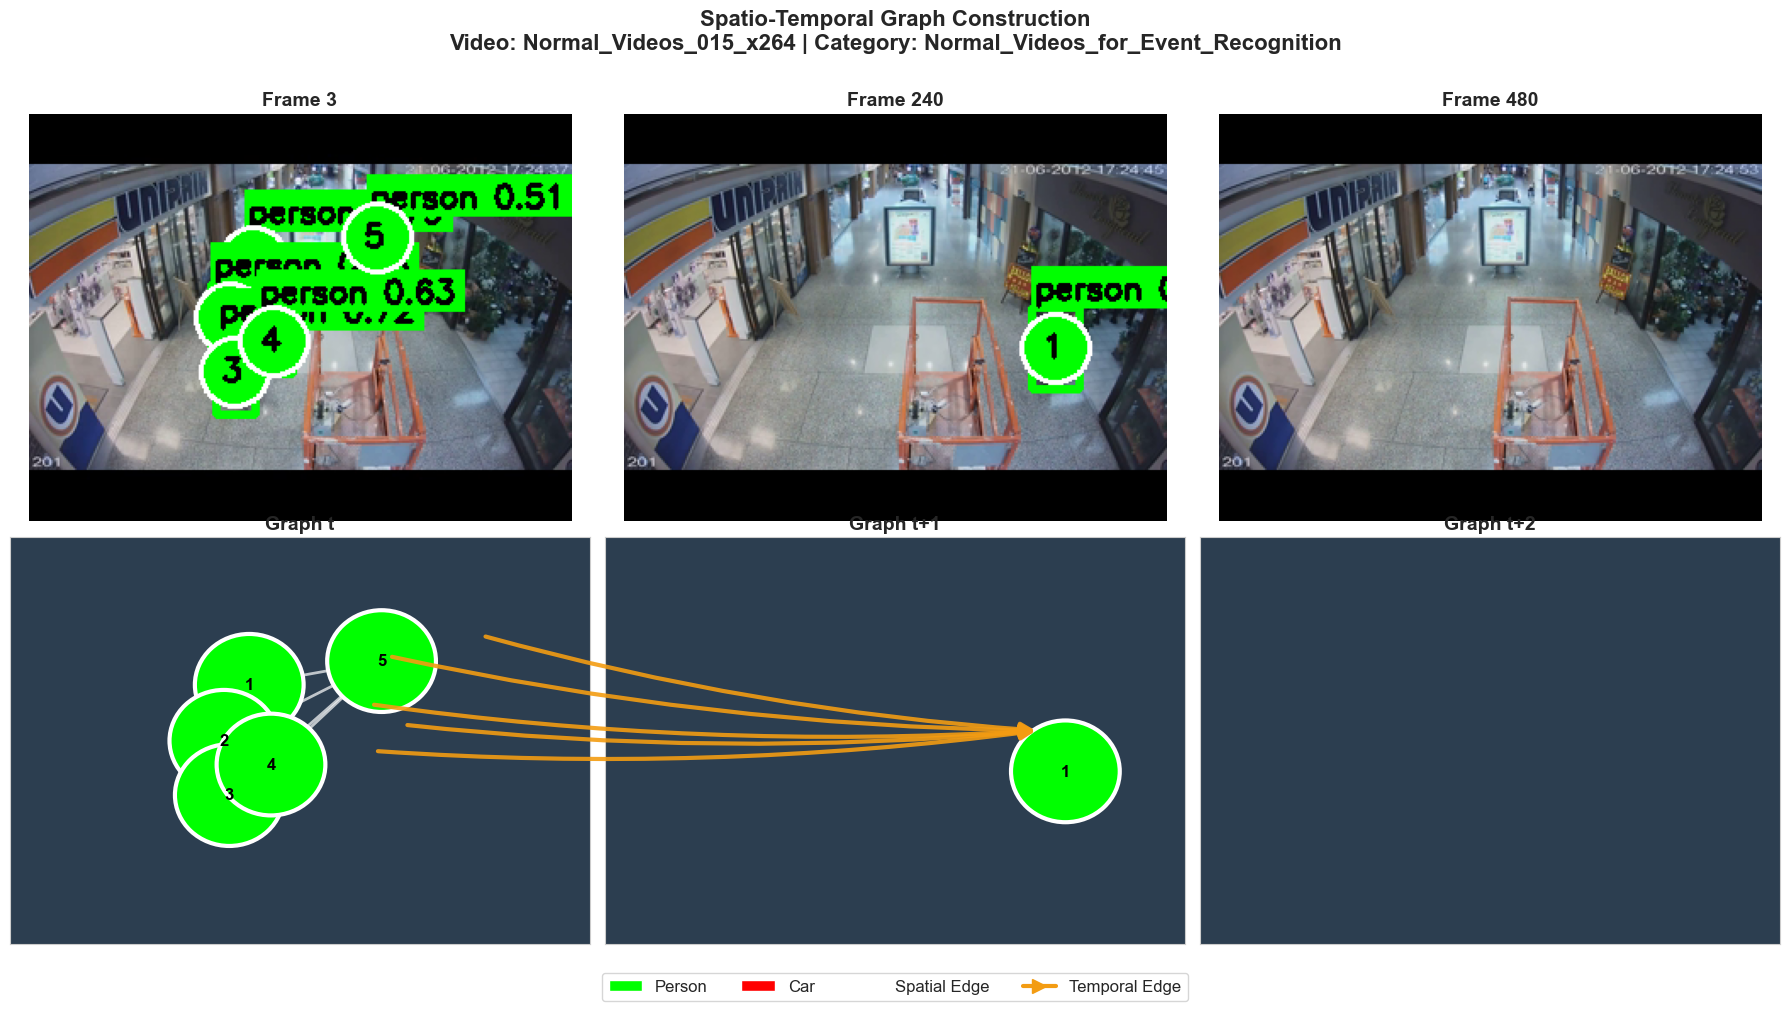


📊 Normal: Normal_Videos_050_x264
✅ Saved: c:\Kuliah\TA\TA BARU\DatasetTA\project_data\analysis\graph_frames_Normal_Videos_050_x264.png


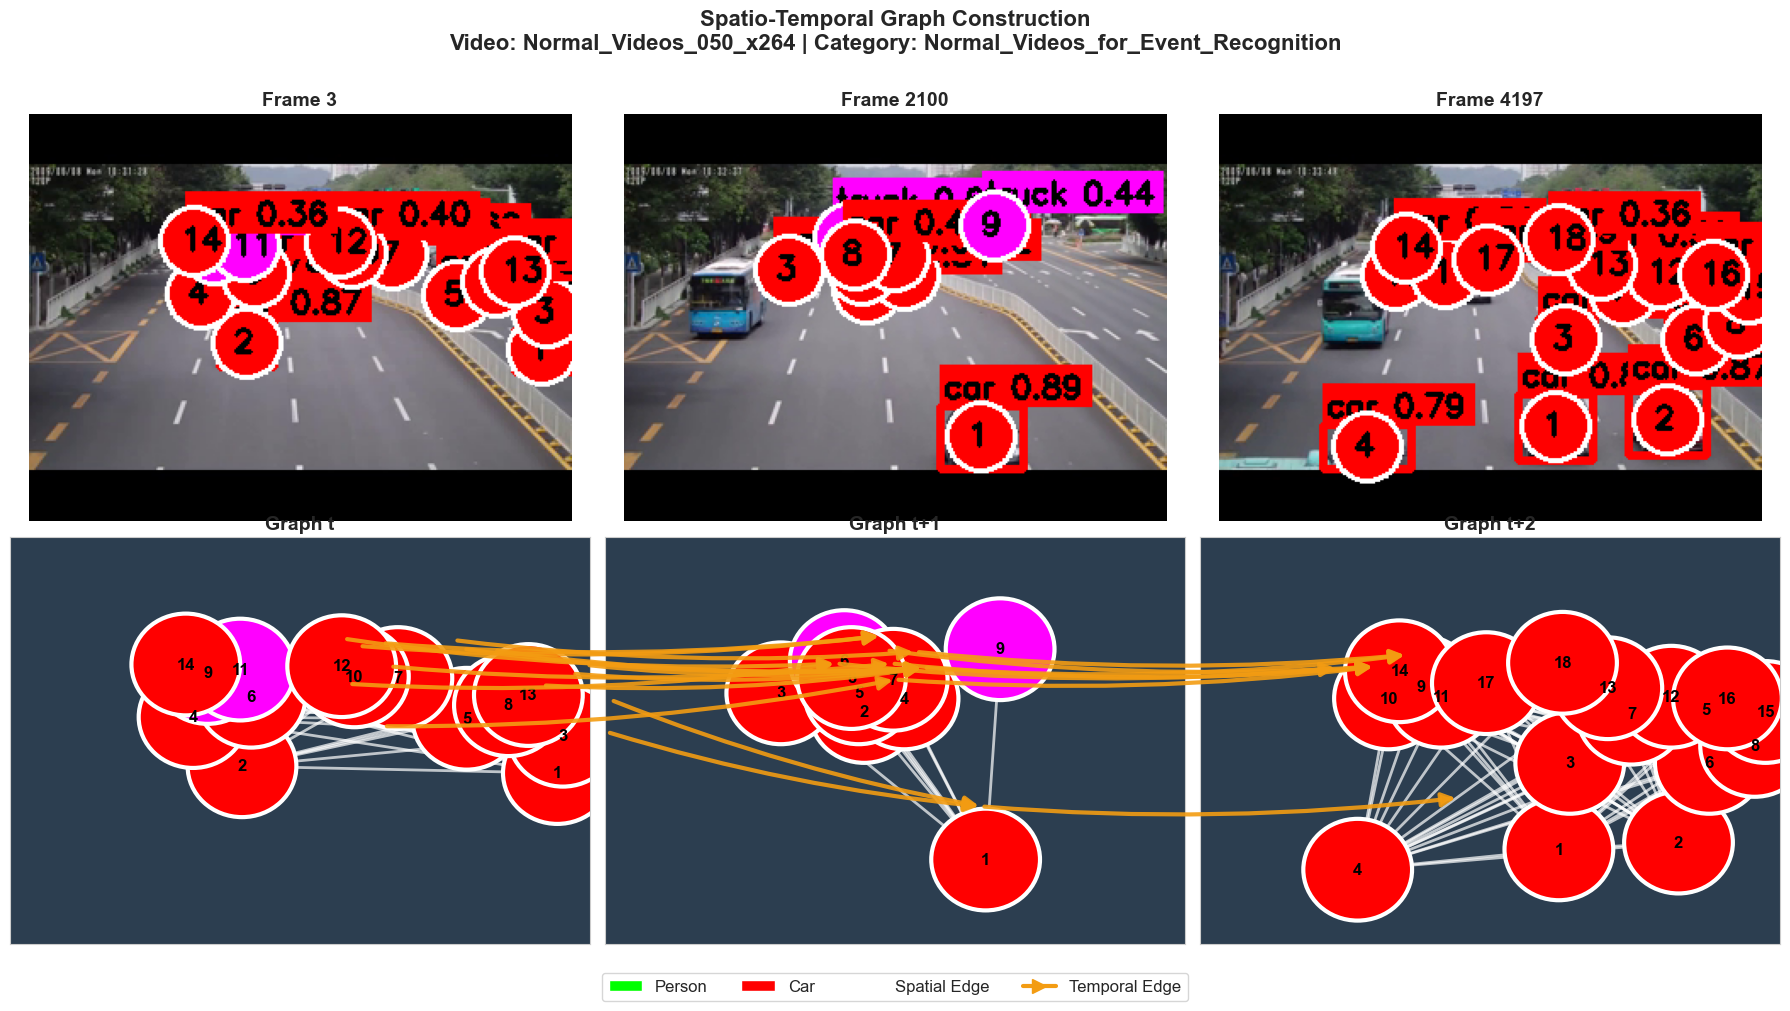

In [15]:
# =============================================================================
# CELL 4c: Visualisasi Graf dengan Frame Video Asli (untuk Paper)
# =============================================================================

def visualize_graph_on_frames(video_path, json_path, num_frames=3, save_path=None):
    """
    Visualisasi graf spatio-temporal di atas frame video asli.
    Menampilkan bounding box, nodes, dan edges.
    """
    # Load detection data
    with open(json_path) as f:
        det = json.load(f)
    
    frames_data = det.get('frames', [])
    if not frames_data:
        print("No frames in detection data")
        return None
    
    # Select frames
    indices = np.linspace(0, len(frames_data)-1, num_frames, dtype=int)
    selected_frames_data = [frames_data[i] for i in indices]
    selected_frame_indices = [frames_data[i].get('frame_index', i) for i in indices]
    
    # Read video frames
    cap = cv2.VideoCapture(str(video_path))
    video_frames = {}
    frame_idx = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        if frame_idx in selected_frame_indices:
            video_frames[frame_idx] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if len(video_frames) >= num_frames:
            break
    cap.release()
    
    if not video_frames:
        print("Could not read video frames")
        return None
    
    # Create figure
    fig, axes = plt.subplots(2, num_frames, figsize=(6*num_frames, 10))
    
    colors = {'person': '#00ff00', 'car': '#ff0000', 'truck': '#ff00ff', 
              'motorcycle': '#ffff00', 'bicycle': '#00ffff', 'knife': '#ff6600',
              'dog': '#996633', 'fire': '#ff3300', 'default': '#ffffff'}
    
    all_centers = {}  # Store centers for temporal edges
    
    for col, (frame_data, frame_idx) in enumerate(zip(selected_frames_data, selected_frame_indices)):
        objects = frame_data.get('objects', [])
        
        # Get frame image
        if frame_idx in video_frames:
            frame_img = video_frames[frame_idx].copy()
        else:
            # Use closest available frame
            closest_idx = min(video_frames.keys(), key=lambda x: abs(x - frame_idx))
            frame_img = video_frames[closest_idx].copy()
        
        h, w = frame_img.shape[:2]
        
        # Top row: Frame with bounding boxes
        ax_frame = axes[0, col]
        
        centers = []
        for i, obj in enumerate(objects):
            bbox = obj.get('bbox', [0,0,100,100])
            x1, y1, x2, y2 = map(int, bbox)
            label = obj.get('label', 'object')
            conf = obj.get('conf', 0.5)
            color_hex = colors.get(label, colors['default'])
            
            # Convert hex to RGB
            color_rgb = tuple(int(color_hex.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
            
            # Draw bounding box
            cv2.rectangle(frame_img, (x1, y1), (x2, y2), color_rgb, 3)
            
            # Draw label background
            label_text = f'{label} {conf:.2f}'
            (tw, th), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(frame_img, (x1, y1-th-10), (x1+tw+5, y1), color_rgb, -1)
            cv2.putText(frame_img, label_text, (x1+2, y1-5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)
            
            # Store center
            cx, cy = (x1+x2)//2, (y1+y2)//2
            centers.append((cx, cy, label, i))
            
            # Draw node number
            cv2.circle(frame_img, (cx, cy), 20, color_rgb, -1)
            cv2.circle(frame_img, (cx, cy), 20, (255,255,255), 2)
            cv2.putText(frame_img, str(i+1), (cx-8, cy+5), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)
        
        all_centers[col] = centers
        
        ax_frame.imshow(frame_img)
        ax_frame.set_title(f'Frame {frame_idx}', fontsize=14, fontweight='bold')
        ax_frame.axis('off')
        
        # Bottom row: Graph representation
        ax_graph = axes[1, col]
        ax_graph.set_xlim(0, w)
        ax_graph.set_ylim(h, 0)
        ax_graph.set_facecolor('#2c3e50')
        ax_graph.set_title(f'Graph t+{col}' if col > 0 else 'Graph t', 
                          fontsize=14, fontweight='bold')
        
        # Draw spatial edges
        for i, (cx1, cy1, _, _) in enumerate(centers):
            for j, (cx2, cy2, _, _) in enumerate(centers):
                if i >= j:
                    continue
                dist = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
                if dist < GRAPH_DISTANCE_THRESH * 3:  # Spatial threshold
                    ax_graph.plot([cx1, cx2], [cy1, cy2], 'w-', 
                                 linewidth=2, alpha=0.7, zorder=1)
        
        # Draw nodes
        for cx, cy, label, idx in centers:
            color = colors.get(label, colors['default'])
            circle = plt.Circle((cx, cy), 30, color=color, 
                               ec='white', linewidth=3, zorder=3)
            ax_graph.add_patch(circle)
            ax_graph.text(cx, cy, str(idx+1), ha='center', va='center',
                         fontsize=12, fontweight='bold', color='black', zorder=4)
        
        ax_graph.set_xticks([])
        ax_graph.set_yticks([])
    
    # Draw temporal edges between graph panels
    for col in range(num_frames - 1):
        if col not in all_centers or col + 1 not in all_centers:
            continue
        
        for cx1, cy1, label1, _ in all_centers[col]:
            best_match = None
            best_dist = float('inf')
            for cx2, cy2, label2, _ in all_centers[col + 1]:
                if label1 == label2:
                    dist = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
                    if dist < best_dist:
                        best_dist = dist
                        best_match = (cx2, cy2)
            
            if best_match and best_dist < GRAPH_DISTANCE_THRESH * 5:
                # Draw on bottom row
                ax1 = axes[1, col]
                ax2 = axes[1, col + 1]
                
                # Get figure coordinates
                ax1_pos = ax1.get_position()
                ax2_pos = ax2.get_position()
                
                h_img = video_frames[list(video_frames.keys())[0]].shape[0]
                w_img = video_frames[list(video_frames.keys())[0]].shape[1]
                
                x1_norm = cx1 / w_img
                y1_norm = cy1 / h_img
                x2_norm = best_match[0] / w_img
                y2_norm = best_match[1] / h_img
                
                x1_fig = ax1_pos.x0 + x1_norm * ax1_pos.width
                y1_fig = ax1_pos.y0 + (1 - y1_norm) * ax1_pos.height
                x2_fig = ax2_pos.x0 + x2_norm * ax2_pos.width
                y2_fig = ax2_pos.y0 + (1 - y2_norm) * ax2_pos.height
                
                arrow = mpatches.FancyArrowPatch(
                    (x1_fig, y1_fig), (x2_fig, y2_fig),
                    transform=fig.transFigure,
                    arrowstyle='-|>', mutation_scale=20,
                    color='#f39c12', linewidth=3, alpha=0.9,
                    connectionstyle='arc3,rad=0.05'
                )
                fig.patches.append(arrow)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='#00ff00', edgecolor='white', label='Person'),
        mpatches.Patch(facecolor='#ff0000', edgecolor='white', label='Car'),
        Line2D([0], [0], color='white', linewidth=2, label='Spatial Edge'),
        Line2D([0], [0], color='#f39c12', linewidth=3, marker='>', 
               markersize=10, label='Temporal Edge'),
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=4,
              fontsize=12, bbox_to_anchor=(0.5, -0.02))
    
    # Title
    video_name = det.get('video', 'Unknown')
    category = det.get('category', 'Unknown')
    fig.suptitle(f'Spatio-Temporal Graph Construction\nVideo: {video_name} | Category: {category}', 
                fontsize=16, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f'✅ Saved: {save_path}')
    
    plt.show()
    return fig

# =============================================================================
# Generate visualization with real frames
# =============================================================================
print('🎬 VISUALISASI GRAF DENGAN FRAME ASLI')
print('='*60)

# Find matching video and detection pairs
det_files = list(DETECTIONS_DIR.rglob('*.json'))
video_files = list(RAW_DIR.rglob('*.mp4')) + list(RAW_DIR.rglob('*.avi'))

# Create mapping
video_map = {v.stem: v for v in video_files}

samples_processed = 0
for det_path in det_files:
    video_name = det_path.stem
    if video_name in video_map:
        video_path = video_map[video_name]
        
        # Check if anomaly or normal
        is_anom = any(c in str(det_path) for c in ANOM_CLASSES)
        label = 'Anomaly' if is_anom else 'Normal'
        
        print(f'\n📊 {label}: {video_name}')
        save_path = ANALYSIS_DIR / f'graph_frames_{video_name}.png'
        
        try:
            visualize_graph_on_frames(video_path, det_path, num_frames=3, save_path=save_path)
            samples_processed += 1
        except Exception as e:
            print(f'   Error: {e}')
        
        if samples_processed >= 2:  # Process 2 samples
            break

if samples_processed == 0:
    print('⚠️ No matching video-detection pairs found.')

In [ ]:
# =============================================================================
# CELL 4d: VISUALISASI LENGKAP UNTUK PAPER - Semua Komponen Rancangan Sistem
# =============================================================================
# Visualisasi:
# 1. Arsitektur Pipeline Keseluruhan
# 2. Node Features (10 dimensi)
# 3. Arsitektur STGNN
# 4. Arsitektur Transformer
# 5. Focal Loss Comparison
# 6. Dataset Distribution
# =============================================================================

from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

# =============================================================================
# 1. ARSITEKTUR PIPELINE KESELURUHAN
# =============================================================================
def visualize_pipeline_architecture(save_path=None):
    """Visualisasi alur pipeline dari video hingga prediksi."""
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_xlim(0, 16)
    ax.set_ylim(0, 6)
    ax.axis('off')
    
    # Colors
    colors = {
        'input': '#3498db',
        'process': '#2ecc71',
        'model': '#9b59b6',
        'output': '#e74c3c'
    }
    
    # Pipeline stages
    stages = [
        ('Video\nInput', 1, colors['input']),
        ('Frame\nSampling', 3, colors['process']),
        ('YOLO\nDetection', 5, colors['process']),
        ('Graph\nConstruction', 7, colors['process']),
        ('STGNN', 9, colors['model']),
        ('Transformer', 11, colors['model']),
        ('Classifier', 13, colors['model']),
        ('Prediction', 15, colors['output']),
    ]
    
    # Draw boxes and arrows
    for i, (label, x, color) in enumerate(stages):
        # Box
        box = FancyBboxPatch((x-0.8, 2), 1.6, 2, boxstyle="round,pad=0.1",
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
        ax.add_patch(box)
        ax.text(x, 3, label, ha='center', va='center', fontsize=11, 
               fontweight='bold', color='white')
        
        # Arrow to next
        if i < len(stages) - 1:
            ax.annotate('', xy=(stages[i+1][1]-0.9, 3), xytext=(x+0.9, 3),
                       arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    
    # Add descriptions below
    descriptions = [
        'Raw\n.mp4/.avi',
        'Skip\nevery 2',
        'Bbox +\nConfidence',
        'Nodes +\nEdges',
        'Graph\nEmbedding',
        'Temporal\nContext',
        'Softmax\n2 classes',
        'Normal/\nAnomaly'
    ]
    for i, (desc, (_, x, _)) in enumerate(zip(descriptions, stages)):
        ax.text(x, 1.3, desc, ha='center', va='center', fontsize=9, 
               color='#7f8c8d', style='italic')
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor=colors['input'], label='Input'),
        mpatches.Patch(facecolor=colors['process'], label='Preprocessing'),
        mpatches.Patch(facecolor=colors['model'], label='Model'),
        mpatches.Patch(facecolor=colors['output'], label='Output'),
    ]
    ax.legend(handles=legend_elements, loc='upper center', ncol=4, 
             fontsize=10, bbox_to_anchor=(0.5, 1.15))
    
    plt.title('Pipeline Arsitektur Sistem Deteksi Anomali', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f'✅ Saved: {save_path}')
    plt.show()

# =============================================================================
# 2. VISUALISASI NODE FEATURES (10 DIMENSI)
# =============================================================================
def visualize_node_features(save_path=None):
    """Visualisasi 10 dimensi fitur node."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Bounding box illustration
    ax1 = axes[0]
    ax1.set_xlim(0, 400)
    ax1.set_ylim(400, 0)
    ax1.set_facecolor('#ecf0f1')
    
    # Draw bounding box
    x1, y1, x2, y2 = 100, 80, 250, 350
    rect = Rectangle((x1, y1), x2-x1, y2-y1, fill=False, 
                     edgecolor='#e74c3c', linewidth=3)
    ax1.add_patch(rect)
    
    # Annotations
    ax1.plot(x1, y1, 'ro', markersize=10)
    ax1.text(x1-10, y1-10, '(x1, y1)', fontsize=10, ha='right')
    ax1.plot(x2, y2, 'ro', markersize=10)
    ax1.text(x2+10, y2+10, '(x2, y2)', fontsize=10)
    
    # Center point
    cx, cy = (x1+x2)/2, (y1+y2)/2
    ax1.plot(cx, cy, 'b*', markersize=15)
    ax1.text(cx+10, cy, f'center\n({cx:.0f}, {cy:.0f})', fontsize=9)
    
    # Width and height
    ax1.annotate('', xy=(x2, y1+20), xytext=(x1, y1+20),
                arrowprops=dict(arrowstyle='<->', color='#27ae60', lw=2))
    ax1.text((x1+x2)/2, y1+10, f'width={x2-x1}', ha='center', fontsize=9, color='#27ae60')
    
    ax1.annotate('', xy=(x2+20, y2), xytext=(x2+20, y1),
                arrowprops=dict(arrowstyle='<->', color='#3498db', lw=2))
    ax1.text(x2+30, (y1+y2)/2, f'height={y2-y1}', fontsize=9, color='#3498db', rotation=90, va='center')
    
    # Confidence label
    ax1.text((x1+x2)/2, y1-15, 'person (conf=0.92)', ha='center', fontsize=11, 
            fontweight='bold', color='#e74c3c')
    
    ax1.set_title('Bounding Box Components', fontsize=12, fontweight='bold')
    ax1.set_xlabel('X coordinate')
    ax1.set_ylabel('Y coordinate')
    
    # Right: Feature table
    ax2 = axes[1]
    ax2.axis('off')
    
    features = [
        ('0', 'x1', '100', 'Koordinat kiri'),
        ('1', 'y1', '80', 'Koordinat atas'),
        ('2', 'x2', '250', 'Koordinat kanan'),
        ('3', 'y2', '350', 'Koordinat bawah'),
        ('4', 'conf', '0.92', 'Confidence score'),
        ('5', 'width', '150', 'Lebar (x2-x1)'),
        ('6', 'height', '270', 'Tinggi (y2-y1)'),
        ('7', 'area', '40500', 'Luas (w×h)'),
        ('8', 'center_x', '175', 'Posisi X tengah'),
        ('9', 'center_y', '215', 'Posisi Y tengah'),
    ]
    
    # Table
    table = ax2.table(cellText=features,
                     colLabels=['Index', 'Feature', 'Value', 'Description'],
                     loc='center',
                     cellLoc='center',
                     colWidths=[0.1, 0.2, 0.15, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.8)
    
    # Style header
    for i in range(4):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    
    # Alternate row colors
    for i in range(1, 11):
        color = '#ecf0f1' if i % 2 == 0 else 'white'
        for j in range(4):
            table[(i, j)].set_facecolor(color)
    
    ax2.set_title('Node Feature Vector (10-dim)', fontsize=12, fontweight='bold', pad=20)
    
    plt.suptitle('Representasi Node dalam Graf', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f'✅ Saved: {save_path}')
    plt.show()

# =============================================================================
# 3. ARSITEKTUR STGNN
# =============================================================================
def visualize_stgnn_architecture(save_path=None):
    """Visualisasi arsitektur STGNN dengan GCN layers dan attention pooling."""
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    # Components from bottom to top
    components = [
        ('Input\nNode Features\n(N × 10)', 11, '#3498db', 2.5),
        ('Feature Encoder\nLinear(10→128) + LayerNorm + GELU', 9.5, '#2ecc71', 1.5),
        ('GCN Layer 1\nGCNConv(128→128) + LayerNorm + GELU', 7.5, '#9b59b6', 1.5),
        ('GCN Layer 2\nGCNConv(128→128) + LayerNorm + GELU', 5.5, '#9b59b6', 1.5),
        ('GCN Layer 3\nGCNConv(128→128) + LayerNorm + GELU', 3.5, '#9b59b6', 1.5),
        ('Attention Pooling\nα = softmax(MLP(h)), z = Σ(αᵢ × hᵢ)', 1.5, '#e74c3c', 1.5),
    ]
    
    for label, y, color, height in components:
        box = FancyBboxPatch((2, y-height/2), 6, height, boxstyle="round,pad=0.05",
                            facecolor=color, edgecolor='white', linewidth=2, alpha=0.9)
        ax.add_patch(box)
        ax.text(5, y, label, ha='center', va='center', fontsize=10, 
               fontweight='bold', color='white')
    
    # Arrows between components
    arrow_ys = [10.2, 8.5, 6.5, 4.5, 2.5]
    for y in arrow_ys:
        ax.annotate('', xy=(5, y-0.3), xytext=(5, y+0.3),
                   arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    
    # Residual connections
    for y in [7.5, 5.5, 3.5]:
        # Draw curved arrow for residual
        ax.annotate('', xy=(8.5, y-0.5), xytext=(8.5, y+2.3),
                   arrowprops=dict(arrowstyle='->', color='#f39c12', lw=2,
                                  connectionstyle='arc3,rad=-0.3'))
        ax.text(9.5, y+0.9, '+', fontsize=16, fontweight='bold', color='#f39c12')
    
    # Output
    box = FancyBboxPatch((3, 0), 4, 0.8, boxstyle="round,pad=0.05",
                        facecolor='#1abc9c', edgecolor='white', linewidth=2)
    ax.add_patch(box)
    ax.text(5, 0.4, 'Output: (1 × 128)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white')
    ax.annotate('', xy=(5, 0.6), xytext=(5, 0.9),
               arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    
    # Legend
    ax.text(10.5, 7, 'Residual\nConnection', fontsize=9, color='#f39c12', 
           fontweight='bold', ha='center')
    
    plt.title('Arsitektur STGNN (Spatio-Temporal Graph Neural Network)', 
             fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f'✅ Saved: {save_path}')
    plt.show()

# =============================================================================
# 4. ARSITEKTUR TRANSFORMER
# =============================================================================
def visualize_transformer_architecture(save_path=None):
    """Visualisasi arsitektur Transformer untuk temporal modeling."""
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Segment inputs (bottom)
    segments = ['Seg 1', 'Seg 2', 'Seg 3', '...', 'Seg 8']
    seg_x = [2, 4, 6, 8, 10]
    
    for i, (seg, x) in enumerate(zip(segments, seg_x)):
        if seg == '...':
            ax.text(x, 1, '...', fontsize=20, ha='center', va='center')
        else:
            box = FancyBboxPatch((x-0.7, 0.5), 1.4, 1, boxstyle="round,pad=0.05",
                                facecolor='#3498db', edgecolor='white', linewidth=2)
            ax.add_patch(box)
            ax.text(x, 1, seg, ha='center', va='center', fontsize=10, 
                   fontweight='bold', color='white')
            ax.text(x, 0.2, '(128-dim)', ha='center', fontsize=8, color='#7f8c8d')
    
    # STGNN label
    ax.text(6, 2.2, '↑ Output from STGNN (per segment)', ha='center', 
           fontsize=10, color='#7f8c8d', style='italic')
    
    # Positional Encoding
    box = FancyBboxPatch((1.5, 2.8), 9, 0.8, boxstyle="round,pad=0.05",
                        facecolor='#f39c12', edgecolor='white', linewidth=2)
    ax.add_patch(box)
    ax.text(6, 3.2, '+ Positional Encoding', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white')
    
    # Transformer Encoder Layer 1
    box = FancyBboxPatch((1.5, 4), 9, 1.8, boxstyle="round,pad=0.05",
                        facecolor='#9b59b6', edgecolor='white', linewidth=2)
    ax.add_patch(box)
    ax.text(6, 5.2, 'Multi-Head Self-Attention (4 heads)', ha='center', 
           fontsize=10, fontweight='bold', color='white')
    ax.text(6, 4.6, 'Feed-Forward Network (128→256→128)', ha='center', 
           fontsize=10, color='white')
    ax.text(11, 4.9, 'Layer 1', fontsize=9, color='#9b59b6', fontweight='bold')
    
    # Transformer Encoder Layer 2
    box = FancyBboxPatch((1.5, 6.2), 9, 1.8, boxstyle="round,pad=0.05",
                        facecolor='#9b59b6', edgecolor='white', linewidth=2)
    ax.add_patch(box)
    ax.text(6, 7.4, 'Multi-Head Self-Attention (4 heads)', ha='center', 
           fontsize=10, fontweight='bold', color='white')
    ax.text(6, 6.8, 'Feed-Forward Network (128→256→128)', ha='center', 
           fontsize=10, color='white')
    ax.text(11, 7.1, 'Layer 2', fontsize=9, color='#9b59b6', fontweight='bold')
    
    # Mean Pooling
    box = FancyBboxPatch((3, 8.3), 6, 0.8, boxstyle="round,pad=0.05",
                        facecolor='#e74c3c', edgecolor='white', linewidth=2)
    ax.add_patch(box)
    ax.text(6, 8.7, 'Mean Pooling → (1 × 128)', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white')
    
    # Arrows
    ax.annotate('', xy=(6, 2.8), xytext=(6, 1.6),
               arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    ax.annotate('', xy=(6, 4), xytext=(6, 3.6),
               arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    ax.annotate('', xy=(6, 6.2), xytext=(6, 5.8),
               arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    ax.annotate('', xy=(6, 8.3), xytext=(6, 8),
               arrowprops=dict(arrowstyle='->', color='#34495e', lw=2))
    
    # Self-attention illustration (small)
    ax.text(12.5, 5, 'Self-Attention:\nSetiap segment\nmelihat semua\nsegment lain', 
           fontsize=9, ha='center', color='#7f8c8d',
           bbox=dict(boxstyle='round', facecolor='#ecf0f1', alpha=0.8))
    
    plt.title('Arsitektur Transformer Encoder untuk Temporal Modeling', 
             fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f'✅ Saved: {save_path}')
    plt.show()

# =============================================================================
# 5. FOCAL LOSS VS CROSS ENTROPY
# =============================================================================
def visualize_focal_loss(save_path=None):
    """Visualisasi perbandingan Focal Loss vs Cross Entropy."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Loss curves
    ax1 = axes[0]
    p = np.linspace(0.01, 0.99, 100)
    
    # Cross Entropy
    ce = -np.log(p)
    
    # Focal Loss with different gamma
    gamma_values = [0, 0.5, 1, 2, 5]
    colors = plt.cm.viridis(np.linspace(0, 1, len(gamma_values)))
    
    for gamma, color in zip(gamma_values, colors):
        fl = -((1 - p) ** gamma) * np.log(p)
        label = f'γ={gamma}' + (' (CE)' if gamma == 0 else '')
        ax1.plot(p, fl, color=color, linewidth=2, label=label)
    
    ax1.set_xlabel('Probability of Ground Truth Class (p)', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Focal Loss: FL(p) = -(1-p)^γ × log(p)', fontsize=12, fontweight='bold')
    ax1.legend(loc='upper right')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 5)
    ax1.grid(True, alpha=0.3)
    ax1.axvline(0.5, color='red', linestyle='--', alpha=0.5, label='p=0.5')
    
    # Right: Effect explanation
    ax2 = axes[1]
    ax2.axis('off')
    
    # Easy vs Hard examples
    data = [
        ['', 'Cross Entropy', 'Focal Loss (γ=2)'],
        ['Easy Example\n(p=0.9)', 'Loss = 0.105', 'Loss = 0.001'],
        ['Hard Example\n(p=0.1)', 'Loss = 2.303', 'Loss = 1.866'],
        ['Ratio\n(Hard/Easy)', '22x', '1866x'],
    ]
    
    table = ax2.table(cellText=data,
                     loc='center',
                     cellLoc='center',
                     colWidths=[0.3, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.5)
    
    # Style
    for i in range(4):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(color='white', fontweight='bold')
    
    ax2.set_title('Efek Focal Loss pada Easy vs Hard Examples', 
                 fontsize=12, fontweight='bold', pad=20)
    
    # Add explanation text
    ax2.text(0.5, 0.1, 
            'Focal Loss mengurangi kontribusi easy examples (well-classified)\n'
            'dan fokus pada hard examples (misclassified)',
            ha='center', fontsize=10, style='italic', color='#7f8c8d',
            transform=ax2.transAxes)
    
    plt.suptitle('Perbandingan Cross Entropy vs Focal Loss', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f'✅ Saved: {save_path}')
    plt.show()

# =============================================================================
# 6. DATASET DISTRIBUTION
# =============================================================================
def visualize_dataset_distribution(save_path=None):
    """Visualisasi distribusi dataset UCF-Crime."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Data
    categories = ['Normal', 'Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary',
                 'Explosion', 'Fighting', 'Robbery', 'Shooting', 'Shoplifting',
                 'Stealing', 'Vandalism']
    counts = [1150, 50, 50, 50, 50, 100, 50, 50, 150, 50, 50, 100, 50]
    
    # Left: Pie chart (Normal vs Anomaly)
    ax1 = axes[0]
    sizes = [1150, 800]
    labels = ['Normal\n(59%)', 'Anomaly\n(41%)']
    colors = ['#2ecc71', '#e74c3c']
    explode = (0, 0.05)
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.0f%%',
           shadow=True, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax1.set_title('Distribusi Label', fontsize=12, fontweight='bold')
    
    # Middle: Bar chart (all categories)
    ax2 = axes[1]
    colors = ['#2ecc71'] + ['#e74c3c'] * 12
    bars = ax2.barh(categories, counts, color=colors, edgecolor='white', linewidth=1)
    ax2.set_xlabel('Jumlah Video', fontsize=11)
    ax2.set_title('Distribusi per Kategori', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    
    # Add count labels
    for bar, count in zip(bars, counts):
        ax2.text(count + 20, bar.get_y() + bar.get_height()/2, str(count),
                va='center', fontsize=9)
    
    # Right: Train/Val split
    ax3 = axes[2]
    split_data = {
        'Training': [973, 677],
        'Validation': [172, 120]
    }
    x = np.arange(2)
    width = 0.35
    
    bars1 = ax3.bar(x - width/2, [973, 172], width, label='Normal', color='#2ecc71')
    bars2 = ax3.bar(x + width/2, [677, 120], width, label='Anomaly', color='#e74c3c')
    
    ax3.set_ylabel('Jumlah Video', fontsize=11)
    ax3.set_title('Pembagian Train/Val (85:15)', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Training\n(1650)', 'Validation\n(292)'])
    ax3.legend()
    
    # Add count labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2, height + 10, str(int(height)),
                    ha='center', fontsize=9)
    
    plt.suptitle('Dataset UCF-Crime', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f'✅ Saved: {save_path}')
    plt.show()

# =============================================================================
# GENERATE ALL VISUALIZATIONS
# =============================================================================
print('📊 GENERATING ALL VISUALIZATIONS FOR PAPER')
print('='*60)

print('\n1️⃣ Pipeline Architecture...')
visualize_pipeline_architecture(ANALYSIS_DIR / 'viz_01_pipeline_architecture.png')

print('\n2️⃣ Node Features...')
visualize_node_features(ANALYSIS_DIR / 'viz_02_node_features.png')

print('\n3️⃣ STGNN Architecture...')
visualize_stgnn_architecture(ANALYSIS_DIR / 'viz_03_stgnn_architecture.png')

print('\n4️⃣ Transformer Architecture...')
visualize_transformer_architecture(ANALYSIS_DIR / 'viz_04_transformer_architecture.png')

print('\n5️⃣ Focal Loss Comparison...')
visualize_focal_loss(ANALYSIS_DIR / 'viz_05_focal_loss.png')

print('\n6️⃣ Dataset Distribution...')
visualize_dataset_distribution(ANALYSIS_DIR / 'viz_06_dataset_distribution.png')

print('\n' + '='*60)
print('✅ All visualizations saved to:', ANALYSIS_DIR)
print('='*60)

---
## 5️⃣ Dataset Split

In [7]:
# =============================================================================
# CELL 5: Dataset Class with Stratified Split
# =============================================================================
class GraphVideoDataset(Dataset):
    def __init__(self, graphs_dir, split='train', ratio=0.85, seed=SEED):
        graph_files = sorted(Path(graphs_dir).rglob('*_graph.pt'))
        anom, norm = [], []
        for gp in graph_files:
            path_str = '/'.join(gp.parts)
            is_anom = any(c in path_str for c in ANOM_CLASSES)
            (anom if is_anom else norm).append((gp, int(is_anom)))
        
        rng = np.random.RandomState(seed)
        ai, ni = np.arange(len(anom)), np.arange(len(norm))
        rng.shuffle(ai); rng.shuffle(ni)
        asp, nsp = int(ratio*len(ai)), int(ratio*len(ni))
        
        if split == 'train':
            self.items = [anom[i] for i in ai[:asp]] + [norm[i] for i in ni[:nsp]]
        else:
            self.items = [anom[i] for i in ai[asp:]] + [norm[i] for i in ni[nsp:]]
        rng.shuffle(self.items)
        self.n_anom = sum(1 for _,l in self.items if l==1)
        self.n_norm = len(self.items) - self.n_anom
    
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        gp, lab = self.items[i]
        return torch.load(gp, weights_only=False), lab, gp.stem.replace('_graph','')

train_ds = GraphVideoDataset(GRAPHS_DIR, 'train', 0.85, SEED)
val_ds = GraphVideoDataset(GRAPHS_DIR, 'val', 0.85, SEED)

print('='*60)
print('📊 DATASET SPLIT')
print('='*60)
print(f'Train: {len(train_ds)} (Anom:{train_ds.n_anom}, Norm:{train_ds.n_norm})')
print(f'Val: {len(val_ds)} (Anom:{val_ds.n_anom}, Norm:{val_ds.n_norm})')

pos_weight = train_ds.n_norm / max(train_ds.n_anom, 1)
print(f'\n⚖️ Class weight for Anomaly: {pos_weight:.2f}')

📊 DATASET SPLIT
Train: 1650 (Anom:677, Norm:973)
Val: 292 (Anom:120, Norm:172)

⚖️ Class weight for Anomaly: 1.44


---
## 6️⃣ Model Definition

In [8]:
# =============================================================================
# CELL 6: Model Definition
# =============================================================================
def augment_features(x):
    """Augment 5-dim to 10-dim features."""
    if x.size(1) == 5:
        x1,y1,x2,y2,conf = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4]
        w = (x2-x1).clamp(min=1)
        h = (y2-y1).clamp(min=1)
        x = torch.cat([x, w.unsqueeze(1), h.unsqueeze(1), (w*h).unsqueeze(1),
                       (0.5*(x1+x2)).unsqueeze(1), (0.5*(y1+y2)).unsqueeze(1)], dim=1)
    return x

def norm_feat(x):
    x = augment_features(x)
    fmin, fmax = x.min(0).values, x.max(0).values
    return (x - fmin) / (fmax - fmin).clamp(min=1e-6)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0):
        super().__init__()
        self.alpha, self.gamma, self.ls = alpha, gamma, label_smoothing
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, weight=self.alpha, 
                            label_smoothing=self.ls, reduction='none')
        return (((1 - torch.exp(-ce)) ** self.gamma) * ce).mean()

class STGNN(nn.Module):
    def __init__(self, in_dim=10, hid=HIDDEN_DIM, out=OUTPUT_DIM, layers=NUM_GCN_LAYERS, drop=DROPOUT):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(in_dim, hid), nn.LayerNorm(hid), nn.GELU(), nn.Dropout(drop))
        self.convs = nn.ModuleList([GCNConv(hid, hid) for _ in range(layers)])
        self.norms = nn.ModuleList([nn.LayerNorm(hid) for _ in range(layers)])
        self.att = nn.Sequential(nn.Linear(hid, hid//2), nn.Tanh(), nn.Linear(hid//2, 1))
        self.proj = nn.Linear(hid, out)
    
    def forward(self, x, ei):
        h = self.enc(norm_feat(x))
        for conv, ln in zip(self.convs, self.norms):
            h = h + F.gelu(ln(conv(h, ei)))
        att = torch.softmax(self.att(h).squeeze(-1), 0)
        return self.proj((h * att.unsqueeze(-1)).sum(0, keepdim=True))

class Transformer(nn.Module):
    def __init__(self, dim=OUTPUT_DIM, heads=4, layers=2, drop=DROPOUT):
        super().__init__()
        enc = nn.TransformerEncoderLayer(dim, heads, dim*2, drop, 'gelu', batch_first=True)
        self.enc = nn.TransformerEncoder(enc, layers)
    def forward(self, x): return self.enc(x).mean(1)

class AnomalyModel(nn.Module):
    def __init__(self, stgnn, trans, dim=OUTPUT_DIM):
        super().__init__()
        self.stgnn, self.trans = stgnn, trans
        self.cls = nn.Sequential(nn.Linear(dim, dim//2), nn.GELU(), nn.Dropout(DROPOUT), nn.Linear(dim//2, 2))
    
    def forward(self, segs):
        dev = next(self.parameters()).device
        feats = [self.stgnn(g.x.to(dev), g.edge_index.to(dev) if g.edge_index.numel()>0 
                           else torch.empty((2,0), dtype=torch.long, device=dev)) for g in segs]
        return self.cls(self.trans(torch.cat(feats, 0).unsqueeze(0)))

model = AnomalyModel(STGNN(), Transformer()).to(DEVICE)
print(f'🧠 Model: {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters')

🧠 Model: 350,147 parameters


---
## 7️⃣ Training

In [9]:
# =============================================================================
# CELL 7: Training Utilities
# =============================================================================
def limit_nodes(g, max_nodes=MAX_NODES):
    if g.x.size(0) <= max_nodes: return g
    idx = torch.randperm(g.x.size(0))[:max_nodes].sort().values
    N = g.x.size(0)
    mask = torch.zeros(N, dtype=torch.bool); mask[idx] = True
    if g.edge_index.numel() > 0:
        em = mask[g.edge_index[0]] & mask[g.edge_index[1]]
        ei = g.edge_index[:, em]
        mp = torch.full((N,), -1, dtype=torch.long); mp[idx] = torch.arange(len(idx))
        ei = mp[ei]
    else: ei = torch.empty((2,0), dtype=torch.long)
    new_g = Data(x=g.x[idx], edge_index=ei)
    if hasattr(g, 'node_frames'): new_g.node_frames = g.node_frames[idx]
    return new_g

def split_segments(g, max_seg=MAX_SEGMENTS):
    g = limit_nodes(g)
    if not hasattr(g, 'node_frames') or g.node_frames is None: return [g]
    frames = g.node_frames.cpu().numpy()
    uniq = np.unique(frames)
    groups = [[f] for f in uniq] if len(uniq) <= max_seg else np.array_split(uniq, max_seg)
    
    segs = []
    for gr in groups:
        if len(gr) == 0: continue
        mask = np.isin(frames, gr)
        idx = torch.tensor(np.where(mask)[0], dtype=torch.long)
        if len(idx) == 0: continue
        N = g.x.size(0)
        m = torch.zeros(N, dtype=torch.bool); m[idx] = True
        if g.edge_index.numel() > 0:
            em = m[g.edge_index[0]] & m[g.edge_index[1]]
            ei = g.edge_index[:, em]
            mp = torch.full((N,), -1, dtype=torch.long); mp[idx] = torch.arange(len(idx))
            ei = mp[ei]
        else: ei = torch.empty((2,0), dtype=torch.long)
        segs.append(Data(x=g.x[idx], edge_index=ei))
    return segs if segs else [g]

def train_epoch(model, ds, opt, crit, scaler, dev, accum=BATCH_ACCUM):
    model.train(); loss_sum, correct, n = 0, 0, 0
    opt.zero_grad()
    for i, (g, lab, _) in enumerate(tqdm(ds, leave=False, desc='Train')):
        segs = split_segments(g)
        y = torch.tensor([lab], dtype=torch.long, device=dev)
        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(segs)
            loss = crit(logits, y) / accum
        scaler.scale(loss).backward()
        if (i+1) % accum == 0 or i+1 == len(ds):
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update(); opt.zero_grad()
        loss_sum += loss.item() * accum
        correct += int(logits.argmax(1).item() == lab)
        n += 1
        if i % 50 == 0: torch.cuda.empty_cache()
    return loss_sum/n, correct/n

@torch.no_grad()
def evaluate(model, ds, crit, dev):
    model.eval(); loss_sum, correct, n = 0, 0, 0
    ys, ps = [], []
    for i, (g, lab, _) in enumerate(tqdm(ds, leave=False, desc='Eval')):
        segs = split_segments(g)
        y = torch.tensor([lab], dtype=torch.long, device=dev)
        with torch.amp.autocast('cuda', enabled=USE_AMP):
            logits = model(segs)
            loss = crit(logits, y)
        prob = torch.softmax(logits, 1)[0,1].cpu().item()
        loss_sum += loss.item()
        correct += int(logits.argmax(1).item() == lab)
        n += 1; ys.append(lab); ps.append(prob)
        if i % 50 == 0: torch.cuda.empty_cache()
    return {'loss': loss_sum/n, 'acc': correct/n, 'ys': ys, 'ps': ps}

print('✅ Training utilities defined')

✅ Training utilities defined


🏋️ Starting training...


Ep01: TrL=0.2693 TrA=0.4582 | VaL=0.3037 VaA=0.6199 AUC=0.6671
  ✅ Best model saved (AUC=0.6671)


Ep02: TrL=0.2641 TrA=0.5206 | VaL=0.2436 VaA=0.5788 AUC=0.7112
  ✅ Best model saved (AUC=0.7112)


Ep03: TrL=0.2511 TrA=0.5473 | VaL=0.2533 VaA=0.5308 AUC=0.7017


Ep04: TrL=0.2606 TrA=0.5564 | VaL=0.2355 VaA=0.6233 AUC=0.7233
  ✅ Best model saved (AUC=0.7233)


Ep05: TrL=0.2606 TrA=0.5406 | VaL=0.2899 VaA=0.5890 AUC=0.6917


Ep06: TrL=0.2559 TrA=0.4333 | VaL=0.2580 VaA=0.6404 AUC=0.7078


Ep07: TrL=0.2539 TrA=0.5570 | VaL=0.2402 VaA=0.6918 AUC=0.7508
  ✅ Best model saved (AUC=0.7508)


Ep08: TrL=0.2483 TrA=0.6255 | VaL=0.2748 VaA=0.6678 AUC=0.7395


Ep09: TrL=0.2471 TrA=0.6091 | VaL=0.2641 VaA=0.6849 AUC=0.7313


Ep10: TrL=0.2539 TrA=0.5945 | VaL=0.3582 VaA=0.6473 AUC=0.6471


Ep11: TrL=0.2487 TrA=0.6036 | VaL=0.2700 VaA=0.6610 AUC=0.6953


Ep12: TrL=0.2464 TrA=0.6079 | VaL=0.2531 VaA=0.6849 AUC=0.7060


Ep13: TrL=0.2442 TrA=0.6467 | VaL=0.2582 VaA=0.6130 AUC=0.7293


Ep14: TrL=0.2456 TrA=0.6582 | VaL=0.2477 VaA=0.7021 AUC=0.7432


Ep15: TrL=0.2461 TrA=0.6558 | VaL=0.2678 VaA=0.6301 AUC=0.7302
⏹️ Early stopping


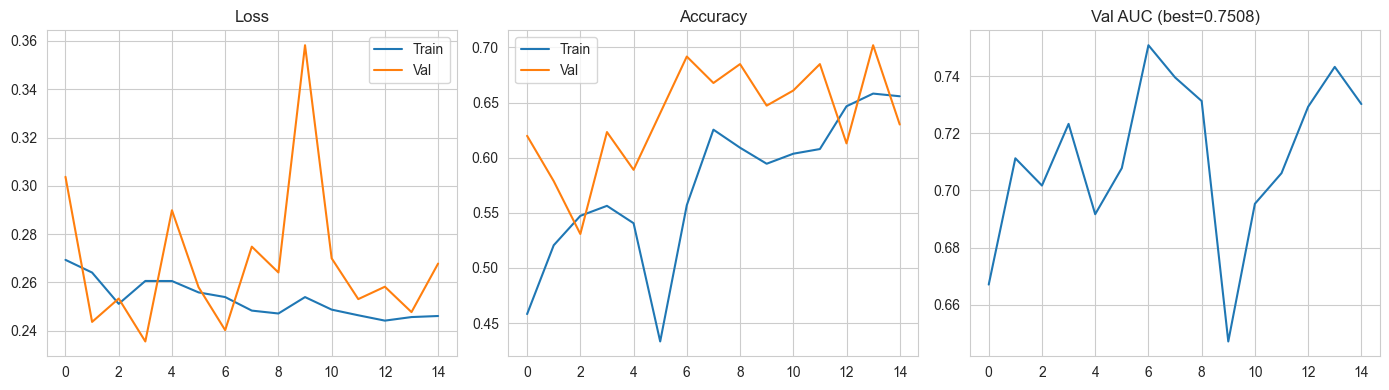

In [10]:
# =============================================================================
# CELL 8: Training Loop
# =============================================================================
if RUN_TRAINING:
    torch.cuda.empty_cache(); gc.collect()
    
    crit = FocalLoss(torch.tensor([1.0, pos_weight], device=DEVICE), gamma=2.0, label_smoothing=LABEL_SMOOTHING)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, EPOCHS, eta_min=LR_MIN)
    scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)
    
    best_auc, patience_cnt = 0, 0
    hist = {'tl':[], 'ta':[], 'vl':[], 'va':[], 'auc':[]}
    
    print('🏋️ Starting training...')
    for ep in range(EPOCHS):
        tl, ta = train_epoch(model, train_ds, opt, crit, scaler, DEVICE)
        vr = evaluate(model, val_ds, crit, DEVICE)
        try: auc = roc_auc_score(vr['ys'], vr['ps'])
        except: auc = 0.5
        sched.step()
        
        hist['tl'].append(tl); hist['ta'].append(ta)
        hist['vl'].append(vr['loss']); hist['va'].append(vr['acc']); hist['auc'].append(auc)
        
        print(f"Ep{ep+1:02d}: TrL={tl:.4f} TrA={ta:.4f} | VaL={vr['loss']:.4f} VaA={vr['acc']:.4f} AUC={auc:.4f}")
        
        if auc > best_auc:
            best_auc = auc; patience_cnt = 0
            torch.save(model.state_dict(), MODELS_DIR/'best_model.pt')
            print(f'  ✅ Best model saved (AUC={auc:.4f})')
        else:
            patience_cnt += 1
        if patience_cnt >= PATIENCE:
            print('⏹️ Early stopping'); break
        torch.cuda.empty_cache()
    
    # Plot
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(hist['tl'], label='Train'); ax[0].plot(hist['vl'], label='Val')
    ax[0].legend(); ax[0].set_title('Loss')
    ax[1].plot(hist['ta'], label='Train'); ax[1].plot(hist['va'], label='Val')
    ax[1].legend(); ax[1].set_title('Accuracy')
    ax[2].plot(hist['auc']); ax[2].set_title(f'Val AUC (best={best_auc:.4f})')
    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR/'training_curves.png', dpi=150)
    plt.show()
else:
    mp = MODELS_DIR/'best_model.pt'
    if mp.exists():
        model.load_state_dict(torch.load(mp, map_location=DEVICE))
        print(f'📂 Loaded model from {mp}')
    else:
        print('⚠️ No trained model found')

---
## 8️⃣ Evaluation

📂 Loaded best model



📊 EVALUATION RESULTS
Best Threshold: 0.4297
AUC-ROC: 0.7487
Best F1: 0.6570

              precision    recall  f1-score   support

      Normal     0.7852    0.6163    0.6906       172
     Anomaly     0.5796    0.7583    0.6570       120

    accuracy                         0.6747       292
   macro avg     0.6824    0.6873    0.6738       292
weighted avg     0.7007    0.6747    0.6768       292

Sensitivity (Anomaly Recall): 0.7583
Specificity (Normal Recall): 0.6163


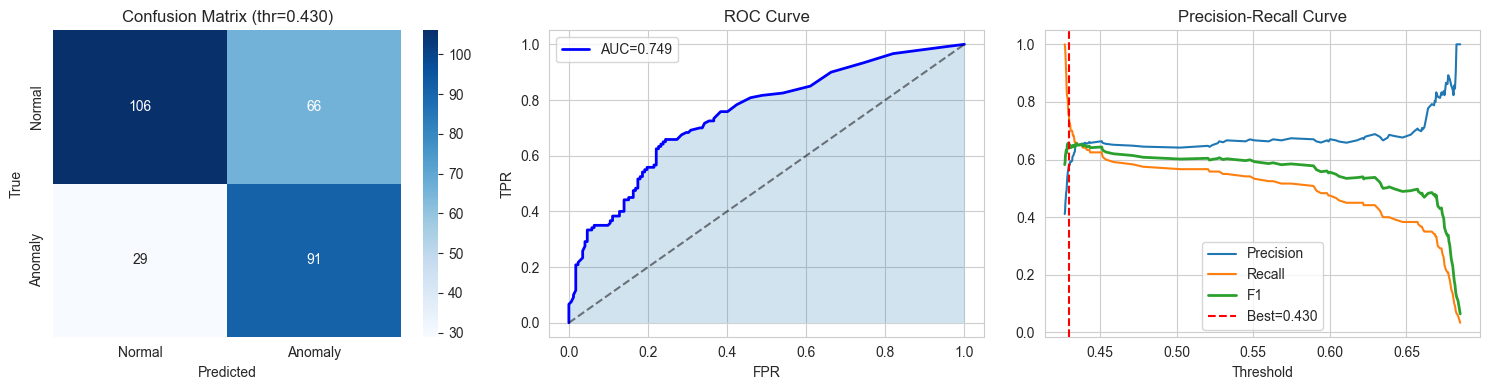

In [11]:
# =============================================================================
# CELL 9: Final Evaluation
# =============================================================================
mp = MODELS_DIR/'best_model.pt'
if mp.exists(): 
    model.load_state_dict(torch.load(mp, map_location=DEVICE))
    print(f'📂 Loaded best model')

crit = nn.CrossEntropyLoss()
res = evaluate(model, val_ds, crit, DEVICE)
ys, ps = np.array(res['ys']), np.array(res['ps'])

# Best threshold by F1
prec, rec, thr = precision_recall_curve(ys, ps)
f1 = 2*prec*rec/(prec+rec+1e-8)
best_idx = np.argmax(f1[:-1])
best_thr = thr[best_idx]
preds = (ps >= best_thr).astype(int)

auc = roc_auc_score(ys, ps)
print('\n' + '='*60)
print(f'📊 EVALUATION RESULTS')
print('='*60)
print(f'Best Threshold: {best_thr:.4f}')
print(f'AUC-ROC: {auc:.4f}')
print(f'Best F1: {f1[best_idx]:.4f}')
print('\n' + classification_report(ys, preds, target_names=['Normal','Anomaly'], digits=4))

cm = confusion_matrix(ys, preds)
tn, fp, fn, tp = cm.ravel()
print(f'Sensitivity (Anomaly Recall): {tp/(tp+fn):.4f}')
print(f'Specificity (Normal Recall): {tn/(tn+fp):.4f}')

# Plots
fig, ax = plt.subplots(1,3,figsize=(15,4))

if sns: sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], 
                    xticklabels=['Normal','Anomaly'], yticklabels=['Normal','Anomaly'])
ax[0].set_title(f'Confusion Matrix (thr={best_thr:.3f})')
ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('True')

fpr, tpr, _ = roc_curve(ys, ps)
ax[1].plot(fpr, tpr, 'b-', lw=2, label=f'AUC={auc:.3f}')
ax[1].plot([0,1],[0,1],'k--', alpha=0.5)
ax[1].fill_between(fpr, tpr, alpha=0.2)
ax[1].legend(); ax[1].set_title('ROC Curve')
ax[1].set_xlabel('FPR'); ax[1].set_ylabel('TPR')

ax[2].plot(thr, prec[:-1], label='Precision')
ax[2].plot(thr, rec[:-1], label='Recall')
ax[2].plot(thr, f1[:-1], label='F1', lw=2)
ax[2].axvline(best_thr, color='r', ls='--', label=f'Best={best_thr:.3f}')
ax[2].legend(); ax[2].set_title('Precision-Recall Curve')
ax[2].set_xlabel('Threshold')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR/'evaluation_results.png', dpi=150)
plt.show()

# Save results
with open(ANALYSIS_DIR/'results.json', 'w') as f:
    json.dump({'auc': float(auc), 'best_threshold': float(best_thr), 
               'best_f1': float(f1[best_idx]), 'accuracy': float(res['acc'])}, f, indent=2)

---
## 9️⃣ Inference

🎯 INFERENCE WITH FRAME VISUALIZATION



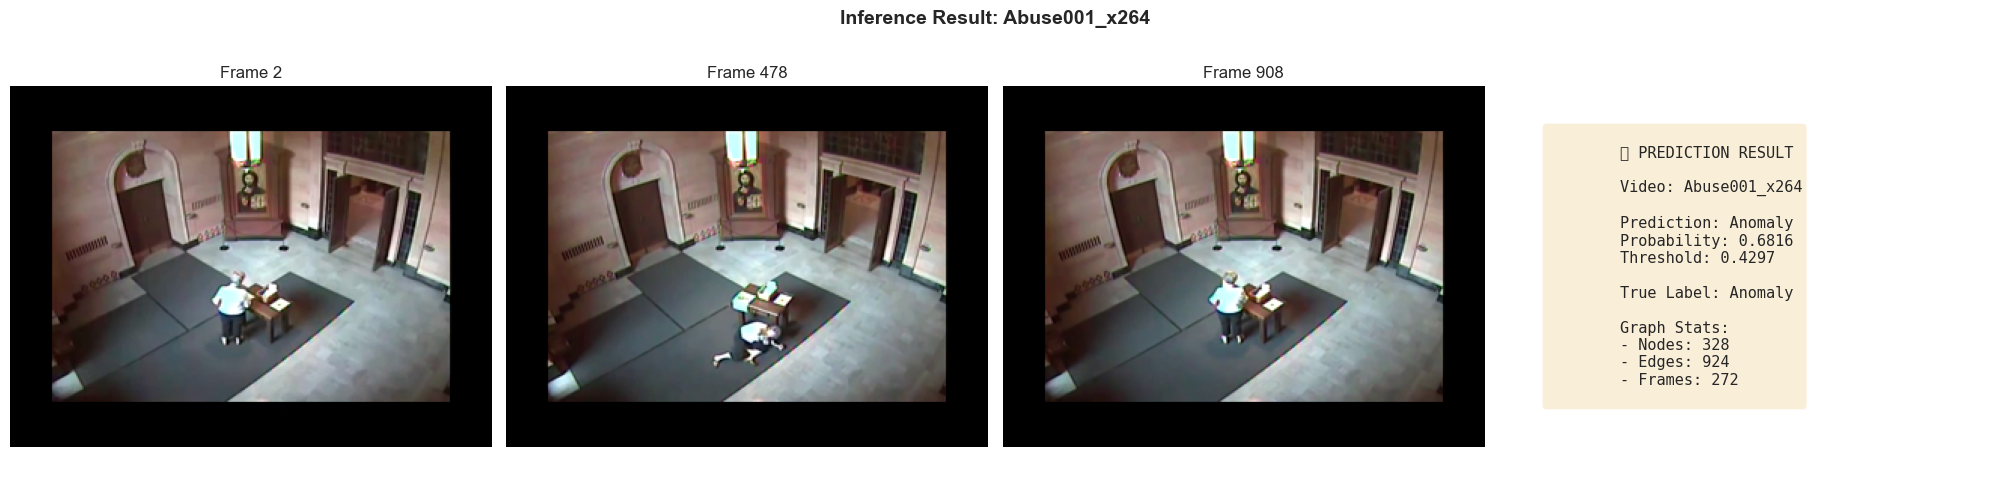

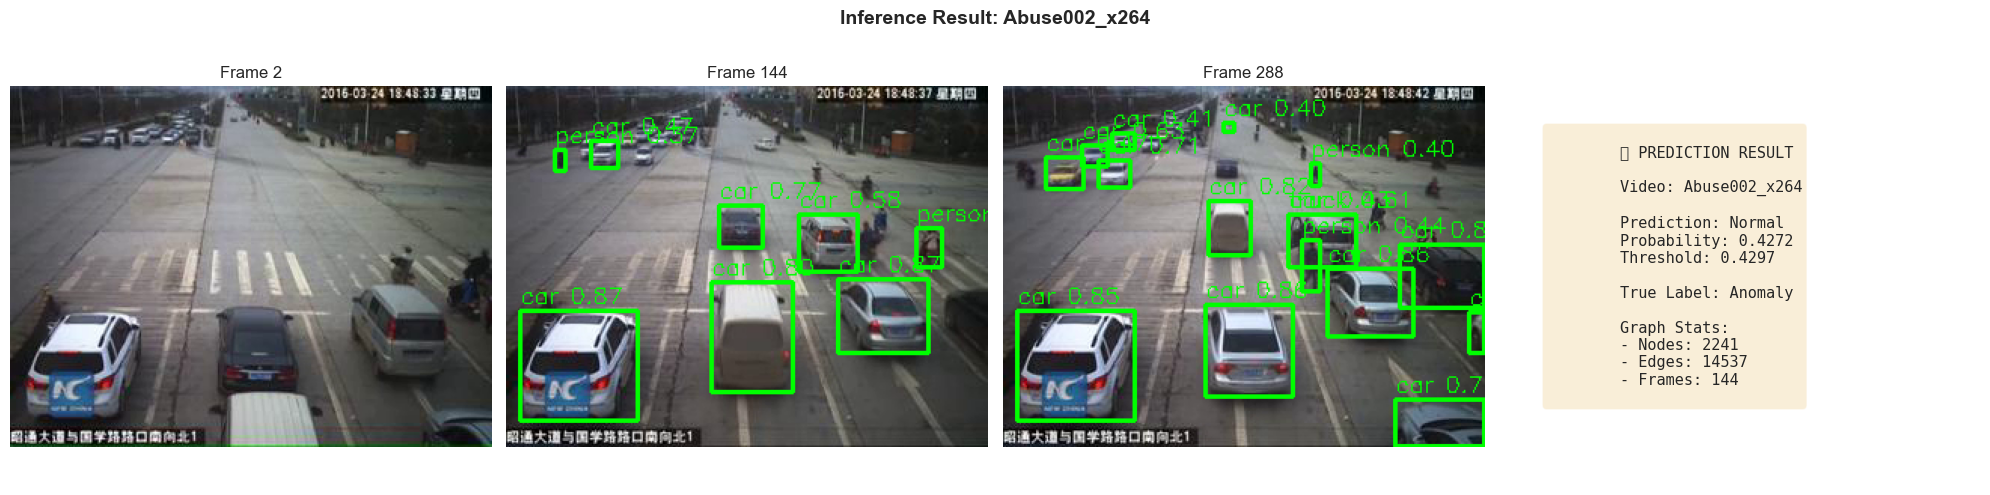

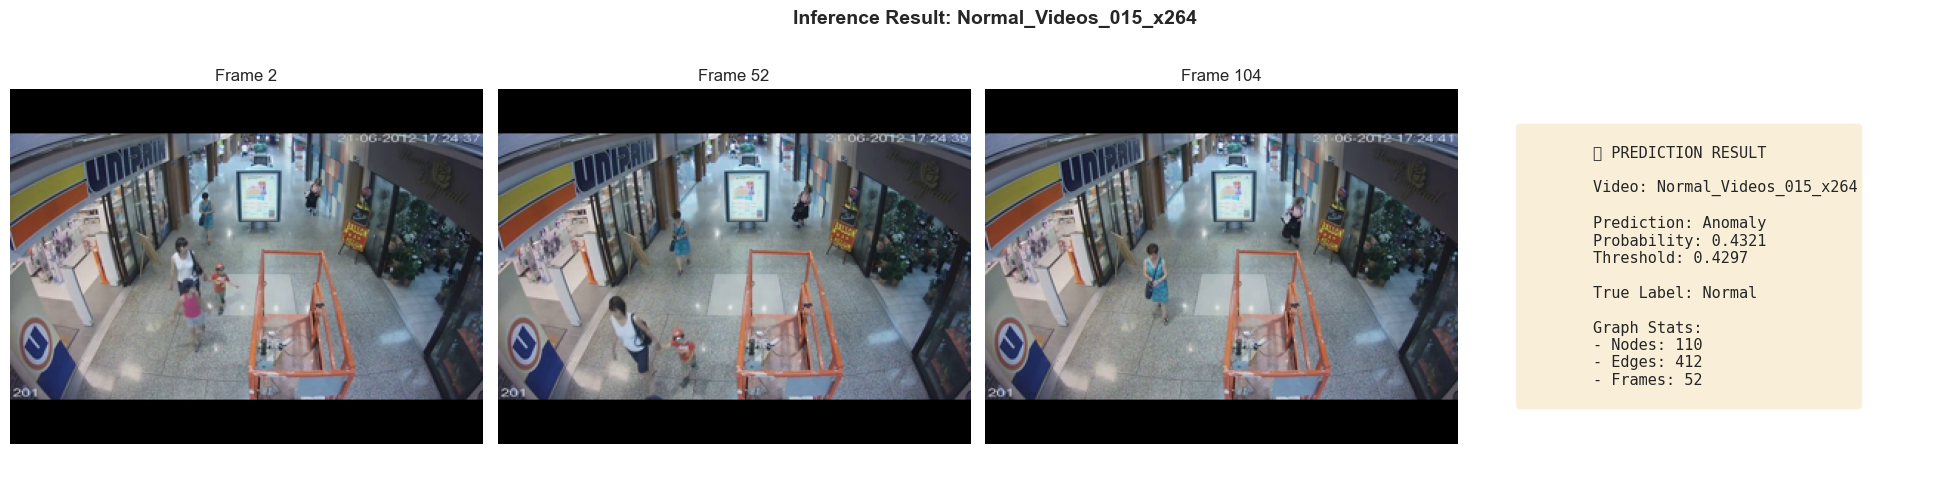

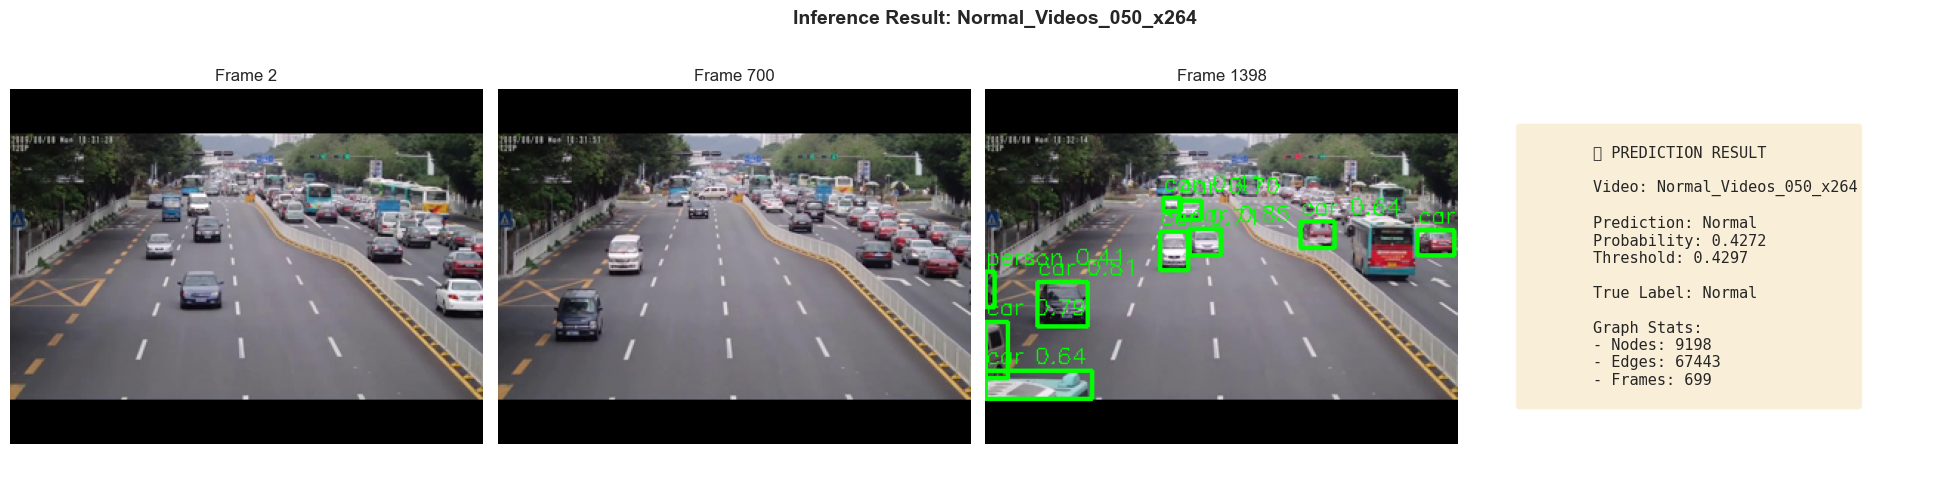

In [12]:
# =============================================================================
# CELL 10: Single Video Inference with Frame Visualization
# =============================================================================
@torch.no_grad()
def predict_video(graph_path, model, threshold=0.5):
    """Predict anomaly for a single video graph."""
    model.eval()
    g = torch.load(graph_path, weights_only=False)
    segs = split_segments(g)
    
    with torch.amp.autocast('cuda', enabled=USE_AMP):
        logits = model(segs)
    
    prob = torch.softmax(logits, 1)[0,1].cpu().item()
    pred = 'Anomaly' if prob >= threshold else 'Normal'
    
    return {'video': getattr(g, 'video_name', graph_path.stem),
            'probability': prob, 'prediction': pred, 'threshold': threshold,
            'graph': g}

def visualize_inference_with_frames(graph_path, model, threshold=0.5, num_frames=3):
    """Visualize inference result with video frames and bounding boxes."""
    # Get prediction
    result = predict_video(graph_path, model, threshold)
    g = result['graph']
    video_name = result['video']
    
    # Find video file
    video_path = None
    for ext in ['.mp4', '.avi', '.mkv']:
        candidates = list(RAW_DIR.rglob(f'{video_name}*{ext}'))
        if candidates:
            video_path = candidates[0]
            break
    
    # Find detection JSON
    det_path = None
    candidates = list(DETECTIONS_DIR.rglob(f'{video_name}.json'))
    if candidates:
        det_path = candidates[0]
    
    # Load detections
    detections = {}
    if det_path and det_path.exists():
        with open(det_path) as f:
            det_data = json.load(f)
        for fr in det_data.get('frames', []):
            detections[fr['frame_index']] = fr['objects']
    
    # Get frames to show
    if hasattr(g, 'node_frames'):
        unique_frames = sorted(set(g.node_frames.cpu().numpy().tolist()))
        # Select evenly spaced frames
        if len(unique_frames) >= num_frames:
            indices = np.linspace(0, len(unique_frames)-1, num_frames, dtype=int)
            selected_frames = [unique_frames[i] for i in indices]
        else:
            selected_frames = unique_frames[:num_frames]
    else:
        selected_frames = [2, 10, 20]  # default
    
    # Read frames from video
    frames_with_boxes = []
    if video_path and video_path.exists():
        cap = cv2.VideoCapture(str(video_path))
        frame_idx = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_idx += 1
            
            if frame_idx in selected_frames:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Draw bounding boxes
                if frame_idx in detections:
                    for obj in detections[frame_idx]:
                        bbox = obj['bbox']
                        x1, y1, x2, y2 = map(int, bbox)
                        label = obj.get('label', 'object')
                        conf = obj.get('conf', 0)
                        
                        # Color based on prediction
                        color = (255, 0, 0) if result['prediction'] == 'Anomaly' else (0, 255, 0)
                        
                        cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), color, 2)
                        cv2.putText(frame_rgb, f'{label} {conf:.2f}', (x1, y1-5),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
                
                frames_with_boxes.append((frame_idx, frame_rgb))
            
            if len(frames_with_boxes) >= num_frames:
                break
        cap.release()
    
    # Create visualization
    true_label = 'Anomaly' if any(c in str(graph_path) for c in ANOM_CLASSES) else 'Normal'
    match_symbol = '✅' if result['prediction'] == true_label else '❌'
    
    if frames_with_boxes:
        fig, axes = plt.subplots(1, len(frames_with_boxes) + 1, figsize=(5*(len(frames_with_boxes)+1), 5))
        
        # Plot frames
        for i, (fidx, frame) in enumerate(frames_with_boxes):
            axes[i].imshow(frame)
            axes[i].set_title(f'Frame {fidx}')
            axes[i].axis('off')
        
        # Plot prediction info
        ax_info = axes[-1]
        ax_info.axis('off')
        
        pred_color = 'red' if result['prediction'] == 'Anomaly' else 'green'
        info_text = f"""
        {match_symbol} PREDICTION RESULT
        
        Video: {video_name}
        
        Prediction: {result['prediction']}
        Probability: {result['probability']:.4f}
        Threshold: {threshold:.4f}
        
        True Label: {true_label}
        
        Graph Stats:
        - Nodes: {g.x.size(0)}
        - Edges: {g.edge_index.size(1) if g.edge_index.numel() > 0 else 0}
        - Frames: {len(unique_frames) if hasattr(g, 'node_frames') else 'N/A'}
        """
        ax_info.text(0.1, 0.5, info_text, transform=ax_info.transAxes, fontsize=11,
                    verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.suptitle(f'Inference Result: {video_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(ANALYSIS_DIR / f'inference_{video_name}.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print(f"⚠️ Could not load video frames for {video_name}")
        print(f"   Prediction: {result['prediction']} (prob={result['probability']:.4f})")
    
    return result

# =============================================================================
# Run inference with visualization
# =============================================================================
print('🎯 INFERENCE WITH FRAME VISUALIZATION')
print('='*60)

# Get sample graphs - mix of normal and anomaly
sample_graphs = []
anom_graphs = [gp for gp in GRAPHS_DIR.rglob('*_graph.pt') if any(c in str(gp) for c in ANOM_CLASSES)]
norm_graphs = [gp for gp in GRAPHS_DIR.rglob('*_graph.pt') if not any(c in str(gp) for c in ANOM_CLASSES)]

# Take 2 anomaly and 2 normal samples
sample_graphs = anom_graphs[:2] + norm_graphs[:2]

for gp in sample_graphs:
    print(f'\n{"="*60}')
    result = visualize_inference_with_frames(gp, model, threshold=best_thr, num_frames=3)
    print(f'{"="*60}')

---
## 🔟 Explainability

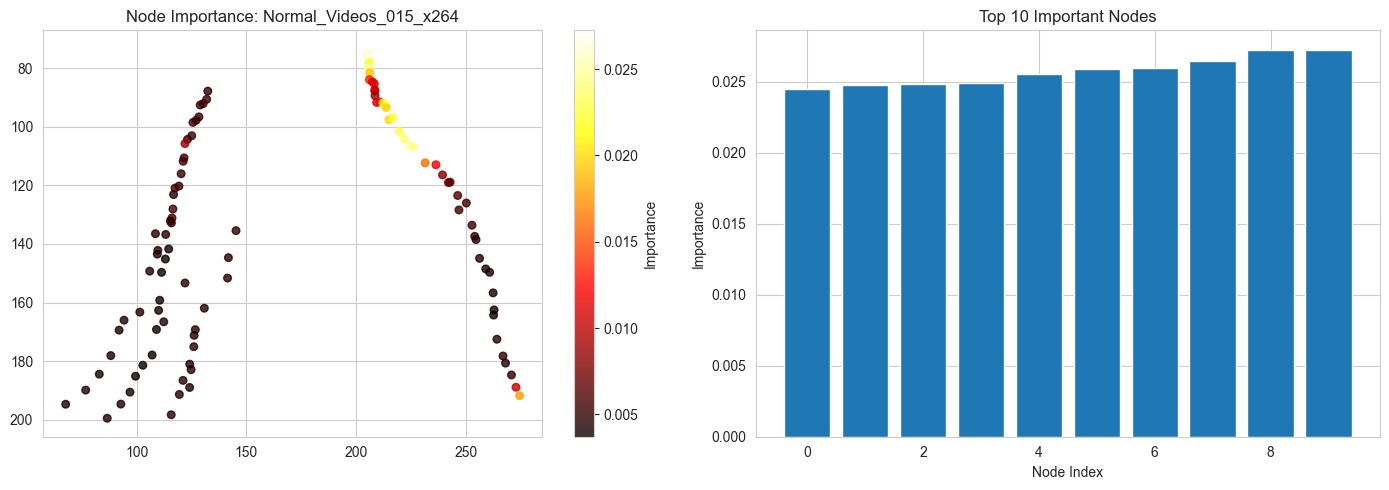


📊 Top 10 important nodes: [84 39 82 44 15  9 27 21  6  4]
   Importance scores: [     0.0245      0.0247      0.0249      0.0249      0.0256      0.0259       0.026      0.0264      0.0272      0.0272]


In [13]:
# =============================================================================
# CELL 11: Node Importance Visualization
# =============================================================================
@torch.no_grad()
def get_node_importance(graph_path, model):
    """Get attention-based node importance scores."""
    model.eval()
    g = torch.load(graph_path, weights_only=False)
    g = limit_nodes(g)
    
    x = g.x.to(DEVICE)
    ei = g.edge_index.to(DEVICE) if g.edge_index.numel()>0 else torch.empty((2,0), dtype=torch.long, device=DEVICE)
    
    # Get attention weights from STGNN
    h = model.stgnn.enc(norm_feat(x))
    for conv, ln in zip(model.stgnn.convs, model.stgnn.norms):
        h = h + F.gelu(ln(conv(h, ei)))
    att = torch.softmax(model.stgnn.att(h).squeeze(-1), 0).cpu().numpy()
    
    return g, att

# Visualize
sample_gp = list(GRAPHS_DIR.rglob('*_graph.pt'))[0]
g, importance = get_node_importance(sample_gp, model)

x = g.x.cpu().numpy()
cx = 0.5 * (x[:,0] + x[:,2])
cy = 0.5 * (x[:,1] + x[:,3])

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Node positions colored by importance
sc = ax[0].scatter(cx, cy, c=importance, cmap='hot', s=30, alpha=0.8)
plt.colorbar(sc, ax=ax[0], label='Importance')
ax[0].set_title(f'Node Importance: {getattr(g, "video_name", "?")}')
ax[0].invert_yaxis()

# Top-K important nodes
topk = 10
top_idx = np.argsort(importance)[-topk:]
ax[1].bar(range(topk), importance[top_idx])
ax[1].set_xlabel('Node Index')
ax[1].set_ylabel('Importance')
ax[1].set_title(f'Top {topk} Important Nodes')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR/'node_importance.png', dpi=150)
plt.show()

print(f'\n📊 Top {topk} important nodes: {top_idx}')
print(f'   Importance scores: {importance[top_idx].round(4)}')

---
## 📝 Summary

Pipeline ini mencakup:
1. **Object Detection** dengan YOLOv9 + Fire model
2. **Graph Building** dengan spatio-temporal edges
3. **STGNN + Transformer** untuk klasifikasi
4. **Focal Loss** untuk handle class imbalance
5. **Best-threshold F1** untuk optimal prediction
6. **Explainability** dengan attention visualization

### Next Steps:
- Tune hyperparameters untuk meningkatkan AUC
- Tambah data augmentation
- Experiment dengan arsitektur berbeda